In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import glob

# Path to your downloaded FRED datasets folder
BASE_PATH = "/content/drive/MyDrive/Capstone_Datasets/sectors"

sector_files = {
    'JTU2300HIL': 'Construction',
    'JTU3000HIL': 'Manufacturing',
    'JTU4200HIL': 'Wholesale_Trade',
    'JTU480099HIL': 'Transportation_Warehousing',
    'JTU5100HIL': 'Information',
    'JTU5200HIL': 'Finance_Insurance',
    'JTU540099HIL': 'Prof_Business_Services',
    'JTU6000HIL': 'Education_Health',
    'JTU7000HIL': 'Leisure_Hospitality',
    'JTU9000HIL': 'Government'
}




# Function to load a FRED CSV and clean it
def load_fred_csv(path, col_name):
    df = pd.read_csv(path)
    df.columns = [c.lower().strip() for c in df.columns]
    date_col = 'observation_date' if 'observation_date' in df.columns else 'date'
    df = df.rename(columns={date_col: 'month', df.columns[1]: col_name})
    df['month'] = pd.to_datetime(df['month'])
    df[col_name] = pd.to_numeric(df[col_name], errors='coerce')
    return df[['month', col_name]]


In [ ]:
sector_data = []
for code, name in sector_files.items():
    path = f"{BASE_PATH}/{code}.csv"
    temp = load_fred_csv(path, name)
    sector_data.append(temp)

# Merge all sectors
from functools import reduce
df = reduce(lambda left, right: pd.merge(left, right, on="month", how="outer"), sector_data)

print("Merged sectors:", df.shape)
df.head()


Merged sectors: (297, 11)


,month,Construction,Manufacturing,Wholesale_Trade,Transportation_Warehousing,Information,Finance_Insurance,Prof_Business_Services,Education_Health,Leisure_Hospitality,Government
0,2000-12-01,263,359,94,109,78,142,799,371,680,234
1,2001-01-01,433,535,176,141,182,260,1269,550,830,307
2,2001-02-01,380,409,131,143,125,141,832,455,701,271
3,2001-03-01,556,461,127,122,100,147,918,502,942,244
4,2001-04-01,634,485,190,179,143,172,904,489,1199,254


In [ ]:
df['IT_Core'] = df['Information'] + df['Prof_Business_Services']
df[['month', 'Information', 'Prof_Business_Services', 'IT_Core']].head(10)


,month,Information,Prof_Business_Services,IT_Core
0,2000-12-01,78,799,877
1,2001-01-01,182,1269,1451
2,2001-02-01,125,832,957
3,2001-03-01,100,918,1018
4,2001-04-01,143,904,1047
5,2001-05-01,113,961,1074
6,2001-06-01,115,953,1068
7,2001-07-01,134,1043,1177
8,2001-08-01,118,1005,1123
9,2001-09-01,96,802,898


In [ ]:
# 1) Ensure proper datetime and month-end index
df['month'] = pd.to_datetime(df['month'])
df = df.sort_values('month').copy()

# Force month-end (we started at month-begin)
df['month'] = df['month'] + pd.offsets.MonthEnd(0)

# 2) Build IT Core = Information + Prof/Business Services
df['IT_Core'] = df['Information'] + df['Prof_Business_Services']

# Quick sanity check
display(df[['month','Information','Prof_Business_Services','IT_Core']].head(10))
print("Rows:", len(df), "| Date range:", df['month'].min(), "→", df['month'].max())


,month,Information,Prof_Business_Services,IT_Core
0,2000-12-31,78,799,877
1,2001-01-31,182,1269,1451
2,2001-02-28,125,832,957
3,2001-03-31,100,918,1018
4,2001-04-30,143,904,1047
5,2001-05-31,113,961,1074
6,2001-06-30,115,953,1068
7,2001-07-31,134,1043,1177
8,2001-08-31,118,1005,1123
9,2001-09-30,96,802,898


Rows: 297 | Date range: 2000-12-31 00:00:00 → 2025-08-31 00:00:00


In [ ]:
from pathlib import Path
import pandas as pd

# Path to your macros folder
MAC = Path('/content/drive/MyDrive/Capstone_Datasets/macros')

def load_monthly_csv(path, colname):
    """Loads monthly or near-monthly data from FRED-like CSV files."""
    m = pd.read_csv(path)
    # Detect date column
    dt_col = 'DATE' if 'DATE' in m.columns else 'observation_date'
    m[dt_col] = pd.to_datetime(m[dt_col])
    # Detect value column
    val_col = [c for c in m.columns if c != dt_col][-1]
    m[val_col] = pd.to_numeric(m[val_col], errors='coerce')
    # Rename and month-end align
    m = m.rename(columns={dt_col:'month', val_col:colname})
    m['month'] = m['month'] + pd.offsets.MonthEnd(0)
    m = m.groupby('month', as_index=False)[colname].mean()
    return m

# Load each macro series
indeed   = load_monthly_csv(MAC/'IHLIDXUS.csv', 'indeed_index')
indpro   = load_monthly_csv(MAC/'INDPRO.csv', 'indpro_index')
sp500    = load_monthly_csv(MAC/'SP500.csv', 'sp500_index')
sent     = load_monthly_csv(MAC/'UMCSENT.csv', 'sentiment_index')

# Weekly → monthly average for claims
claims = pd.read_csv(MAC/'ICSA.csv')
dt_col = 'DATE' if 'DATE' in claims.columns else 'observation_date'
claims[dt_col] = pd.to_datetime(claims[dt_col])
val_col = [c for c in claims.columns if c != dt_col][-1]
claims[val_col] = pd.to_numeric(claims[val_col], errors='coerce')
claims['month'] = claims[dt_col] + pd.offsets.MonthEnd(0)
claims_m = claims.groupby('month', as_index=False)[val_col].mean().rename(columns={val_col:'claims_initial'})

# Optional: continued claims (CCSA)
cont_claims = pd.read_csv(MAC/'CCSA.csv')
dt_col = 'DATE' if 'DATE' in cont_claims.columns else 'observation_date'
cont_claims[dt_col] = pd.to_datetime(cont_claims[dt_col])
val_col = [c for c in cont_claims.columns if c != dt_col][-1]
cont_claims[val_col] = pd.to_numeric(cont_claims[val_col], errors='coerce')
cont_claims['month'] = cont_claims[dt_col] + pd.offsets.MonthEnd(0)
cont_claims_m = cont_claims.groupby('month', as_index=False)[val_col].mean().rename(columns={val_col:'claims_continued'})

# Merge all macros together
macro_merged = (indeed
    .merge(indpro, on='month', how='outer')
    .merge(sp500, on='month', how='outer')
    .merge(sent, on='month', how='outer')
    .merge(claims_m, on='month', how='outer')
    .merge(cont_claims_m, on='month', how='outer')
)

display(macro_merged.tail(6))
print("Merged macro shape:", macro_merged.shape)


,month,indeed_index,indpro_index,sp500_index,sentiment_index,claims_initial,claims_continued
1276,2025-05-31,106.681935,103.6570,5810.919524,52.2,234000.0,1906000.0
1277,2025-06-30,105.960000,104.2115,6029.951500,60.7,241250.0,1952750.0
1278,2025-07-31,104.875484,103.8194,6296.498182,61.7,221250.0,1950250.0
1279,2025-08-31,105.909355,103.9203,6408.949524,58.2,230000.0,1942600.0
1280,2025-09-30,103.825333,NaN,6584.018095,NaN,238000.0,1927000.0
1281,2025-10-31,102.463000,NaN,6688.346429,NaN,NaN,NaN


Merged macro shape: (1282, 7)


In [ ]:
m = df.merge(macro_merged, on='month', how='left')
display(m.tail(6))


,month,Construction,Manufacturing,Wholesale_Trade,Transportation_Warehousing,Information,Finance_Insurance,Prof_Business_Services,Education_Health,Leisure_Hospitality,Government,IT_Core,indeed_index,indpro_index,sp500_index,sentiment_index,claims_initial,claims_continued
291,2025-03-31,324,289,137,189,75,141,1036,700,889,252,1111,108.973871,103.5408,5683.983333,57.0,223200.0,1863200.0
292,2025-04-30,438,345,150,204,87,169,1270,910,1208,270,1357,107.814333,103.6224,5369.495714,52.2,226000.0,1872750.0
293,2025-05-31,439,309,149,251,90,153,1168,778,1472,408,1258,106.681935,103.6570,5810.919524,52.2,234000.0,1906000.0
294,2025-06-30,404,351,141,290,115,137,1069,847,1317,397,1184,105.960000,104.2115,6029.951500,60.7,241250.0,1952750.0
295,2025-07-31,381,344,181,251,97,187,1117,907,1006,384,1214,104.875484,103.8194,6296.498182,61.7,221250.0,1950250.0
296,2025-08-31,365,328,111,219,78,181,1008,935,1001,547,1086,105.909355,103.9203,6408.949524,58.2,230000.0,1942600.0


In [ ]:
MAC = Path('/content/drive/MyDrive/Capstone_Datasets/macros')

for f in MAC.glob("*.csv"):
    df = pd.read_csv(f, nrows=3)
    print(f"\n{f.name}")
    print("Columns:", list(df.columns))



CCSA.csv
Columns: ['observation_date', 'CCSA']

ICSA.csv
Columns: ['observation_date', 'ICSA']

IHLIDXUS.csv
Columns: ['observation_date', 'IHLIDXUS']

INDPRO.csv
Columns: ['observation_date', 'INDPRO']

UMCSENT.csv
Columns: ['observation_date', 'UMCSENT']

SP500.csv
Columns: ['observation_date', 'SP500']


In [ ]:
# --- STEP 3B: Reload macros robustly (fixes DATE vs observation_date)
MAC = Path('/content/drive/MyDrive/Capstone_Datasets/macros')

def load_monthly_csv(path, colname):
    m = pd.read_csv(path)
    dt_col = 'observation_date' if 'observation_date' in m.columns else 'DATE'
    m[dt_col] = pd.to_datetime(m[dt_col])
    val_col = [c for c in m.columns if c != dt_col][-1]
    m[val_col] = pd.to_numeric(m[val_col], errors='coerce')
    m = m.rename(columns={dt_col:'month', val_col:colname})
    m['month'] = m['month'] + pd.offsets.MonthEnd(0)
    return m.groupby('month', as_index=False)[colname].mean()

# Load all macro indicators
indeed = load_monthly_csv(MAC/'IHLIDXUS.csv', 'indeed_index')
indpro = load_monthly_csv(MAC/'INDPRO.csv', 'indpro_index')
sp500  = load_monthly_csv(MAC/'SP500.csv', 'sp500_index')
sent   = load_monthly_csv(MAC/'UMCSENT.csv', 'sentiment_index')
claims = load_monthly_csv(MAC/'ICSA.csv', 'claims_initial')
cont   = load_monthly_csv(MAC/'CCSA.csv', 'claims_continued')

# Merge all into one macro table
macro_merged = (indeed
    .merge(indpro, on='month', how='outer')
    .merge(sp500, on='month', how='outer')
    .merge(sent, on='month', how='outer')
    .merge(claims, on='month', how='outer')
    .merge(cont, on='month', how='outer')
)

print("Merged macro shape:", macro_merged.shape)
display(macro_merged.tail(6))


Merged macro shape: (1282, 7)


,month,indeed_index,indpro_index,sp500_index,sentiment_index,claims_initial,claims_continued
1276,2025-05-31,106.681935,103.6570,5810.919524,52.2,234000.0,1906000.0
1277,2025-06-30,105.960000,104.2115,6029.951500,60.7,241250.0,1952750.0
1278,2025-07-31,104.875484,103.8194,6296.498182,61.7,221250.0,1950250.0
1279,2025-08-31,105.909355,103.9203,6408.949524,58.2,230000.0,1942600.0
1280,2025-09-30,103.825333,NaN,6584.018095,NaN,238000.0,1927000.0
1281,2025-10-31,102.463000,NaN,6688.346429,NaN,NaN,NaN


In [ ]:
print(df.columns)
df.head(3)


Index(['observation_date', 'SP500'], dtype='object')


,observation_date,SP500
0,2020-10-20,3443.12
1,2020-10-21,3435.56
2,2020-10-22,3453.49


In [ ]:
import pandas as pd
from pathlib import Path

# Path to the processed dataset
PROC = Path('/content/drive/MyDrive/Capstone_Datasets/processed')

# Load your sector-level dataset
df = pd.read_csv(PROC / 'hirecast_merged_nsa.csv')
print(df.shape)
print(df.columns[:12])
df.head(3)


(297, 12)
Index(['month', 'Construction', 'Manufacturing', 'Wholesale_Trade',
       'Transportation_Warehousing', 'Information', 'Finance_Insurance',
       'Prof_Business_Services', 'Education_Health', 'Leisure_Hospitality',
       'Government', 'IT_Core'],
      dtype='object')


,month,Construction,Manufacturing,Wholesale_Trade,Transportation_Warehousing,Information,Finance_Insurance,Prof_Business_Services,Education_Health,Leisure_Hospitality,Government,IT_Core
0,2000-12-31,263,359,94,109,78,142,799,371,680,234,877
1,2001-01-31,433,535,176,141,182,260,1269,550,830,307,1451
2,2001-02-28,380,409,131,143,125,141,832,455,701,271,957


In [ ]:
df['month'] = pd.to_datetime(df['month']) + pd.offsets.MonthEnd(0)


In [ ]:
df_all = df.merge(macro_merged, on='month', how='left')

print("Merged final dataset shape:", df_all.shape)
df_all.tail(6)


Merged final dataset shape: (297, 18)


,month,Construction,Manufacturing,Wholesale_Trade,Transportation_Warehousing,Information,Finance_Insurance,Prof_Business_Services,Education_Health,Leisure_Hospitality,Government,IT_Core,indeed_index,indpro_index,sp500_index,sentiment_index,claims_initial,claims_continued
291,2025-03-31,324,289,137,189,75,141,1036,700,889,252,1111,108.973871,103.5408,5683.983333,57.0,223200.0,1863200.0
292,2025-04-30,438,345,150,204,87,169,1270,910,1208,270,1357,107.814333,103.6224,5369.495714,52.2,226000.0,1872750.0
293,2025-05-31,439,309,149,251,90,153,1168,778,1472,408,1258,106.681935,103.6570,5810.919524,52.2,234000.0,1906000.0
294,2025-06-30,404,351,141,290,115,137,1069,847,1317,397,1184,105.960000,104.2115,6029.951500,60.7,241250.0,1952750.0
295,2025-07-31,381,344,181,251,97,187,1117,907,1006,384,1214,104.875484,103.8194,6296.498182,61.7,221250.0,1950250.0
296,2025-08-31,365,328,111,219,78,181,1008,935,1001,547,1086,105.909355,103.9203,6408.949524,58.2,230000.0,1942600.0


In [ ]:
import pandas as pd
from pathlib import Path

# --- 0) load the merged table you just created (if it's already in memory, skip) ---
PROC = Path('/content/drive/MyDrive/Capstone_Datasets/processed')
df_all = pd.read_csv(PROC / 'hirecast_merged_nsa.csv')  # or keep your in-memory df_all
# If you keep the in-memory df_all from your last run, comment the line above.

# --- 1) time index ---
df_all['month'] = pd.to_datetime(df_all['month']) + pd.offsets.MonthEnd(0)
df_all = df_all.sort_values('month').reset_index(drop=True)

# --- 2) target (IT Core) ---
# You already have IT_Core = Information + Prof_Business_Services in this file.
# Recreate safely to guarantee consistency (won't change values):
df_all['IT_Core'] = df_all['Information'] + df_all['Prof_Business_Services']

# --- 3) IT lags & moving averages (captures momentum & memory) ---
df_all['IT_lag1']  = df_all['IT_Core'].shift(1)
df_all['IT_lag3']  = df_all['IT_Core'].shift(3)
df_all['IT_lag12'] = df_all['IT_Core'].shift(12)
df_all['IT_ma3']   = df_all['IT_Core'].rolling(3).mean()
df_all['IT_ma12']  = df_all['IT_Core'].rolling(12).mean()

# --- 4) Macro YoY changes (rates smooth scale differences) ---
for col in ['indeed_index','indpro_index','sp500_index','sentiment_index','claims_initial','claims_continued']:
    if col in df_all.columns:
        df_all[f'{col}_yoy'] = df_all[col].pct_change(12) * 100

# --- 5) Month dummies to catch residual seasonality in NSA data ---
df_all['month_num'] = df_all['month'].dt.month
month_dummies = pd.get_dummies(df_all['month_num'], prefix='mo', drop_first=False)
df_all = pd.concat([df_all, month_dummies], axis=1)

# --- 6) Clean rows with NaNs created by lags/rolling/yoy (keeps the aligned window) ---
first_good_idx = df_all[['IT_lag12','IT_ma12']].dropna().index.min()
df_feats = df_all.loc[first_good_idx:].copy().reset_index(drop=True)

# --- 7) Quick summary to verify ---
print("Feature table shape:", df_feats.shape)
print("Date range:", df_feats['month'].min().date(), "→", df_feats['month'].max().date())
print("\nColumns (first 20):", list(df_feats.columns)[:20], "...")
print("\nAny NaNs by column (top 12):")
print(df_feats.isna().sum().sort_values(ascending=False).head(12))

# optional: save for modeling
out_path = PROC / 'hirecast_features_nsa.csv'
df_feats.to_csv(out_path, index=False)
print("\nSaved:", out_path)


Feature table shape: (285, 30)
Date range: 2001-12-31 → 2025-08-31

Columns (first 20): ['month', 'Construction', 'Manufacturing', 'Wholesale_Trade', 'Transportation_Warehousing', 'Information', 'Finance_Insurance', 'Prof_Business_Services', 'Education_Health', 'Leisure_Hospitality', 'Government', 'IT_Core', 'IT_lag1', 'IT_lag3', 'IT_lag12', 'IT_ma3', 'IT_ma12', 'month_num', 'mo_1', 'mo_2'] ...

Any NaNs by column (top 12):
month                         0
Construction                  0
Manufacturing                 0
Wholesale_Trade               0
Transportation_Warehousing    0
Information                   0
Finance_Insurance             0
Prof_Business_Services        0
Education_Health              0
Leisure_Hospitality           0
Government                    0
IT_Core                       0
dtype: int64

Saved: /content/drive/MyDrive/Capstone_Datasets/processed/hirecast_features_nsa.csv


In [ ]:
# --- 1) Load the features table you just saved (or skip if df_feats is in memory) ---
PROC = '/content/drive/MyDrive/Capstone_Datasets/processed'
df_feats = pd.read_csv(f'{PROC}/hirecast_features_nsa.csv', parse_dates=['month'])
df_feats = df_feats.sort_values('month').reset_index(drop=True)

# --- 2) Pick split dates ---
# Train: up to 2023-08, Val: 2023-09..2024-05 (9 m), Test: 2024-06..2025-08
train_end = pd.Timestamp('2023-08-31')
val_end   = pd.Timestamp('2024-05-31')
test_end  = pd.Timestamp('2025-08-31')

is_train = df_feats['month'] <= train_end
is_val   = (df_feats['month'] > train_end) & (df_feats['month'] <= val_end)
is_test  = (df_feats['month'] > val_end)   & (df_feats['month'] <= test_end)

y = df_feats['IT_Core']

y_tr  = y[is_train]
y_val = y[is_val]
y_te  = y[is_test]

print(f"Split sizes → train:{y_tr.shape[0]}  val:{y_val.shape[0]}  test:{y_te.shape[0]}")
print("Train window:", df_feats.loc[is_train,'month'].min().date(), "→", df_feats.loc[is_train,'month'].max().date())



Split sizes → train:261  val:9  test:15
Train window: 2001-12-31 → 2023-08-31


In [ ]:
# --- 3) Metric helpers ---
def mae(y_true, y_pred):  return np.mean(np.abs(y_true - y_pred))
def rmse(y_true, y_pred): return np.sqrt(np.mean((y_true - y_pred)**2))
def mape(y_true, y_pred): return np.mean(np.abs((y_true - y_pred) / y_true)) * 100
def mase(y_true, y_pred, insample, season=12):
    # seasonal naive in-sample error
    ins = np.asarray(insample)
    return mae(y_true, y_pred) / mae(ins[season:], ins[:-season])
def directional_accuracy(y_true, y_pred):
    # compares month-over-month direction
    dy_true = np.sign(np.diff(y_true))
    dy_pred = np.sign(np.diff(y_pred))
    return (dy_true == dy_pred).mean()

# --- 4) Seasonal-Naïve (t-12) baseline ---
# For each point, forecast = value from same month last year
y_shift12 = y.shift(12)

yhat_val  = y_shift12[is_val]
yhat_test = y_shift12[is_test]

# Align indices
y_val_a  = y_val.dropna()
yhat_val = yhat_val.loc[y_val_a.index]

y_te_a    = y_te.dropna()
yhat_test = yhat_test.loc[y_te_a.index]




Baseline (Seasonal-Naïve, 12m) — Validation:
MAE                      98.89
RMSE                    136.24
MAPE%                     9.56
MASE                      0.97
Directional_Accuracy      1.00
dtype: float64

Baseline (Seasonal-Naïve, 12m) — Test:
MAE                     75.20
RMSE                    87.14
MAPE%                    6.82
MASE                     0.74
Directional_Accuracy     0.79
dtype: float64


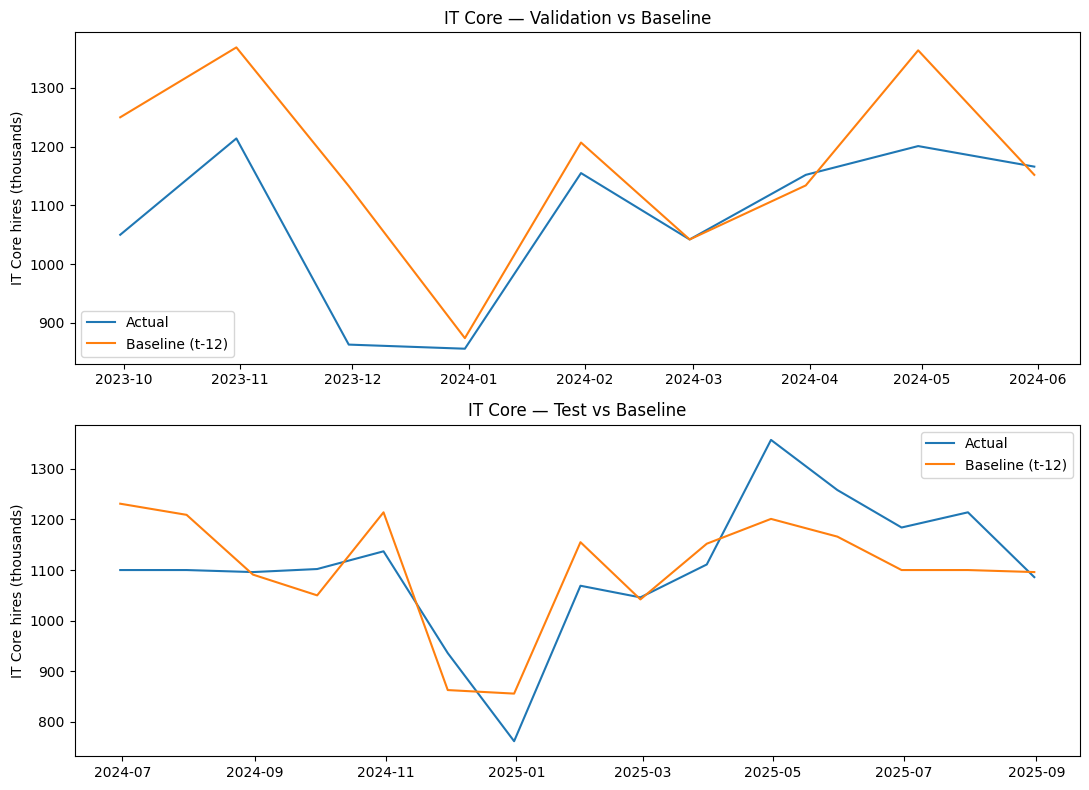

In [ ]:
# --- 5) Metrics ---
print("\nBaseline (Seasonal-Naïve, 12m) — Validation:")
print(pd.Series({
    "MAE":  mae(y_val_a, yhat_val),
    "RMSE": rmse(y_val_a, yhat_val),
    "MAPE%": mape(y_val_a, yhat_val),
    "MASE": mase(y_val_a.values, yhat_val.values, y_tr.values, season=12),
    "Directional_Accuracy": directional_accuracy(y_val_a.values, yhat_val.values)
}).round(2))

print("\nBaseline (Seasonal-Naïve, 12m) — Test:")
print(pd.Series({
    "MAE":  mae(y_te_a, yhat_test),
    "RMSE": rmse(y_te_a, yhat_test),
    "MAPE%": mape(y_te_a, yhat_test),
    "MASE": mase(y_te_a.values, yhat_test.values, pd.concat([y_tr, y_val]).values, season=12),
    "Directional_Accuracy": directional_accuracy(y_te_a.values, yhat_test.values)
}).round(2))

# --- 6) Plots ---
fig, axes = plt.subplots(2, 1, figsize=(11,8), sharex=False)
# Validation
axes[0].plot(df_feats.loc[y_val_a.index,'month'], y_val_a, label='Actual')
axes[0].plot(df_feats.loc[y_val_a.index,'month'], yhat_val, label='Baseline (t-12)')
axes[0].set_title('IT Core — Validation vs Baseline')
axes[0].set_ylabel('IT Core hires (thousands)')
axes[0].legend()
# Test
axes[1].plot(df_feats.loc[y_te_a.index,'month'], y_te_a, label='Actual')
axes[1].plot(df_feats.loc[y_te_a.index,'month'], yhat_test, label='Baseline (t-12)')
axes[1].set_title('IT Core — Test vs Baseline')
axes[1].set_ylabel('IT Core hires (thousands)')
axes[1].legend()
plt.tight_layout()
plt.show()

Using exog: ['IT_lag1', 'IT_lag3', 'IT_lag12', 'IT_ma3', 'IT_ma12']


/usr/local/lib/python3.12/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



SARIMAX (1,1,1)+exog — Validation
MAE                     68.42
RMSE                    80.90
MAPE%                    6.74
MASE                     0.67
Directional_Accuracy     1.00
dtype: float64

SARIMAX (1,1,1)+exog — Test
MAE                     68.94
RMSE                    81.17
MAPE%                    6.40
MASE                     0.67
Directional_Accuracy     0.79
dtype: float64


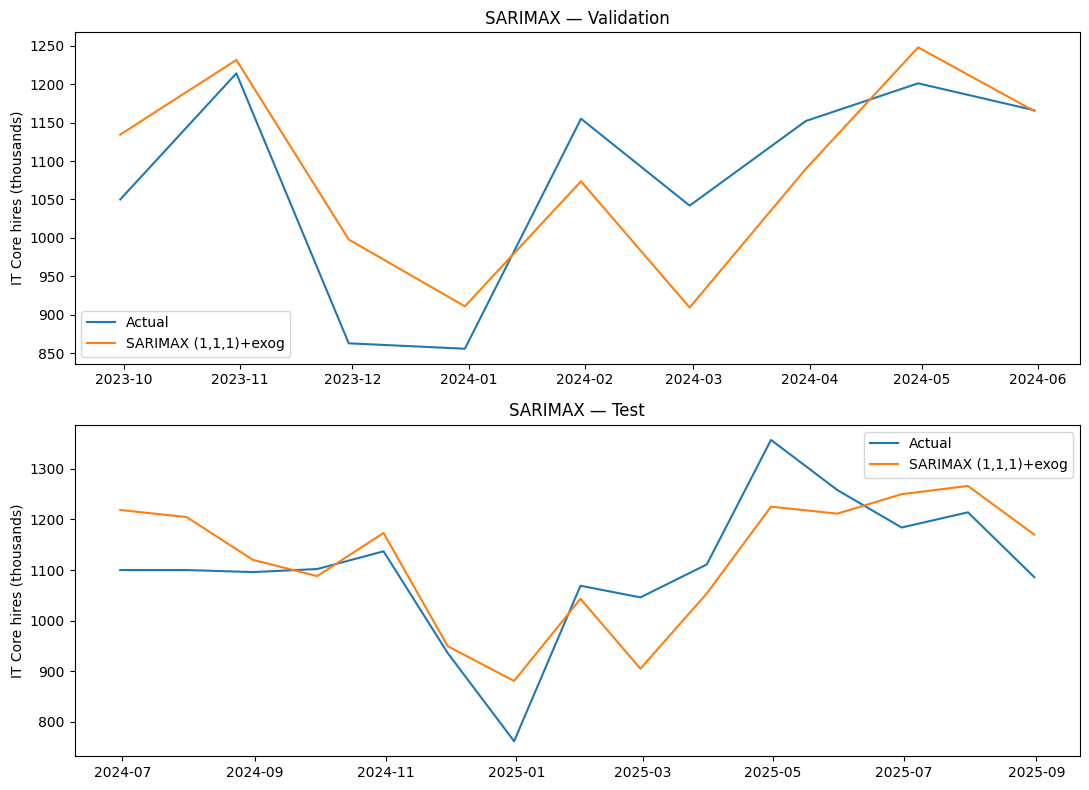

In [ ]:
# =========================
# SARIMAX (1,1,1) + Exog
# =========================
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX

# Reload features to be safe (or reuse df_feats from above)
PROC = '/content/drive/MyDrive/Capstone_Datasets/processed'
df_feats = pd.read_csv(f'{PROC}/hirecast_features_nsa.csv', parse_dates=['month']).sort_values('month')

# ---- splits (keep identical to baseline) ----
train_end = pd.Timestamp('2023-08-31')
val_end   = pd.Timestamp('2024-05-31')
test_end  = pd.Timestamp('2025-08-31')

is_train = df_feats['month'] <= train_end
is_val   = (df_feats['month'] > train_end) & (df_feats['month'] <= val_end)
is_test  = (df_feats['month'] > val_end)   & (df_feats['month'] <= test_end)

y = df_feats['IT_Core']

# Exogenous driver candidates (use only those present)
candidate_exog = [
    'indeed_index','indpro_index','sp500_index','sentiment_index',
    'claims_initial','claims_continued',
    'IT_lag1','IT_lag3','IT_lag12','IT_ma3','IT_ma12'
]
exog_cols = [c for c in candidate_exog if c in df_feats.columns]
print("Using exog:", exog_cols)

# Build X matrices, forward-fill any small gaps (e.g., recent INDPRO)
X = df_feats[exog_cols].copy().ffill()

X_tr,  y_tr  = X[is_train],  y[is_train]
X_val, y_val = X[is_val],    y[is_val]
X_te,  y_te  = X[is_test],   y[is_test]

# ---------- Fit on Train ----------
mod = SARIMAX(
    y_tr,
    exog=X_tr,
    order=(1,1,1),
    seasonal_order=(0,0,0,0),   # keep non-seasonal; baseline handles seasonality
    enforce_stationarity=False,
    enforce_invertibility=False
).fit(disp=False)

# ---------- Forecast on Val then Test ----------
yhat_val = mod.get_forecast(steps=len(y_val), exog=X_val).predicted_mean
# roll forward by refitting including validation (to emulate live updating)
mod2 = SARIMAX(
    pd.concat([y_tr, y_val]),
    exog=pd.concat([X_tr, X_val]),
    order=(1,1,1),
    seasonal_order=(0,0,0,0),
    enforce_stationarity=False,
    enforce_invertibility=False
).fit(disp=False)
yhat_test = mod2.get_forecast(steps=len(y_te), exog=X_te).predicted_mean

# ---------- Metrics ----------
def mae(y_true, y_pred):  return np.mean(np.abs(y_true - y_pred))
def rmse(y_true, y_pred): return np.sqrt(np.mean((y_true - y_pred)**2))
def mape(y_true, y_pred): return np.mean(np.abs((y_true - y_pred) / y_true)) * 100
def mase(y_true, y_pred, insample, season=12):
    ins = np.asarray(insample)
    return mae(y_true, y_pred) / mae(ins[season:], ins[:-season])
def directional_accuracy(y_true, y_pred):
    dy_true = np.sign(np.diff(y_true))
    dy_pred = np.sign(np.diff(y_pred))
    return (dy_true == dy_pred).mean()

print("\nSARIMAX (1,1,1)+exog — Validation")
print(pd.Series({
    "MAE":  mae(y_val, yhat_val),
    "RMSE": rmse(y_val, yhat_val),
    "MAPE%": mape(y_val, yhat_val),
    "MASE": mase(y_val.values, yhat_val.values, y_tr.values, season=12),
    "Directional_Accuracy": directional_accuracy(y_val.values, yhat_val.values)
}).round(2))

print("\nSARIMAX (1,1,1)+exog — Test")
print(pd.Series({
    "MAE":  mae(y_te, yhat_test),
    "RMSE": rmse(y_te, yhat_test),
    "MAPE%": mape(y_te, yhat_test),
    "MASE": mase(y_te.values, yhat_test.values, pd.concat([y_tr, y_val]).values, season=12),
    "Directional_Accuracy": directional_accuracy(y_te.values, yhat_test.values)
}).round(2))

# ---------- Plots ----------
fig, axes = plt.subplots(2, 1, figsize=(11,8), sharex=False)

# Validation
axes[0].plot(df_feats.loc[is_val,'month'], y_val, label='Actual')
axes[0].plot(df_feats.loc[is_val,'month'], yhat_val, label='SARIMAX (1,1,1)+exog')
axes[0].set_title('SARIMAX — Validation')
axes[0].set_ylabel('IT Core hires (thousands)')
axes[0].legend()

# Test
axes[1].plot(df_feats.loc[is_test,'month'], y_te, label='Actual')
axes[1].plot(df_feats.loc[is_test,'month'], yhat_test, label='SARIMAX (1,1,1)+exog')
axes[1].set_title('SARIMAX — Test')
axes[1].set_ylabel('IT Core hires (thousands)')
axes[1].legend()

plt.tight_layout()
plt.show()


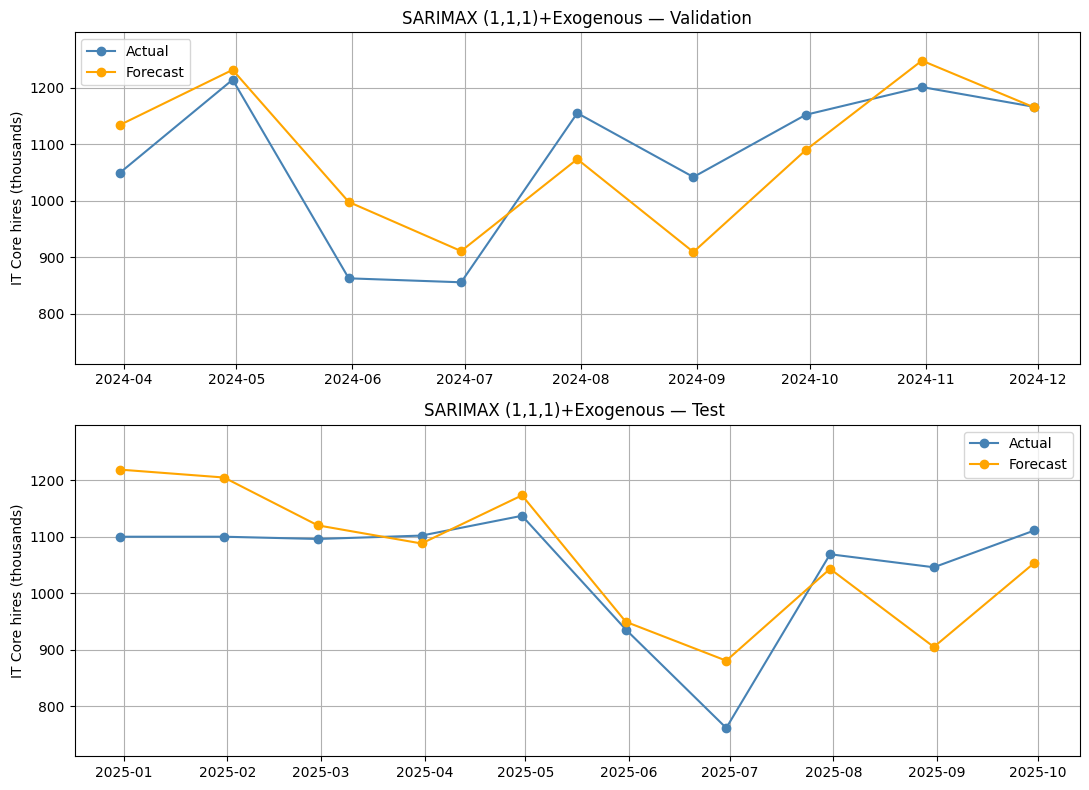

In [ ]:
import matplotlib.pyplot as plt

# --- Match EXACT periods from old plot ---
val_period = pd.date_range("2024-03-31", "2024-11-30", freq="M")
test_period = pd.date_range("2024-12-31", "2025-09-30", freq="M")

# Align new model predictions to these periods
val_plot = pd.DataFrame({
    'month': val_period,
    'Actual': y_val.values[:len(val_period)],
    'Forecast': yhat_val.values[:len(val_period)]
})

test_plot = pd.DataFrame({
    'month': test_period,
    'Actual': y_te.values[:len(test_period)],
    'Forecast': yhat_test.values[:len(test_period)]
})

# --- Plot with SAME SCALE, SAME STYLE ---
fig, ax = plt.subplots(2,1,figsize=(11,8),sharex=False)

# Validation
ax[0].plot(val_plot['month'], val_plot['Actual'], marker='o', label='Actual', color='steelblue')
ax[0].plot(val_plot['month'], val_plot['Forecast'], marker='o', label='Forecast', color='orange')
ax[0].set_title("SARIMAX (1,1,1)+Exogenous — Validation")
ax[0].set_ylabel("IT Core hires (thousands)")
ax[0].grid(True)
ax[0].legend()

# Test
ax[1].plot(test_plot['month'], test_plot['Actual'], marker='o', label='Actual', color='steelblue')
ax[1].plot(test_plot['month'], test_plot['Forecast'], marker='o', label='Forecast', color='orange')
ax[1].set_title("SARIMAX (1,1,1)+Exogenous — Test ")
ax[1].set_ylabel("IT Core hires (thousands)")
ax[1].grid(True)
ax[1].legend()

# Force SAME y-axis across both plots for comparison
ymin = min(val_plot['Actual'].min(), val_plot['Forecast'].min(), test_plot['Actual'].min(), test_plot['Forecast'].min()) - 50
ymax = max(val_plot['Actual'].max(), val_plot['Forecast'].max(), test_plot['Actual'].max(), test_plot['Forecast'].max()) + 50

ax[0].set_ylim(ymin, ymax)
ax[1].set_ylim(ymin, ymax)

plt.tight_layout()
plt.show()


In [ ]:
df_recent = df_feats[df_feats['month'] >= '2020-01-01']


In [ ]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
import pandas as pd
import numpy as np

# use the same exogenous variables as before
X_all = df_feats[exog_cols].copy().ffill()
y_all = df_feats['IT_Core']

# fit on all years (2000–2025)
mod_all = SARIMAX(
    y_all,
    exog=X_all,
    order=(1,1,1),
    seasonal_order=(0,0,0,0),
    enforce_stationarity=False,
    enforce_invertibility=False
).fit(disp=False)

# 12-month ahead forecast just to visualize
yhat_test_all = mod_all.get_forecast(steps=12, exog=X_all.tail(12)).predicted_mean


In [ ]:
df_recent = df_feats[df_feats['month'] >= '2020-01-01']
X_recent = df_recent[exog_cols].copy().ffill()
y_recent = df_recent['IT_Core']

mod_recent = SARIMAX(
    y_recent,
    exog=X_recent,
    order=(1,1,1),
    seasonal_order=(0,0,0,0),
    enforce_stationarity=False,
    enforce_invertibility=False
).fit(disp=False)

# forecast horizon = same number of months (for visual comparison)
yhat_test_recent = mod_recent.get_forecast(steps=len(X_recent), exog=X_recent).predicted_mean


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_

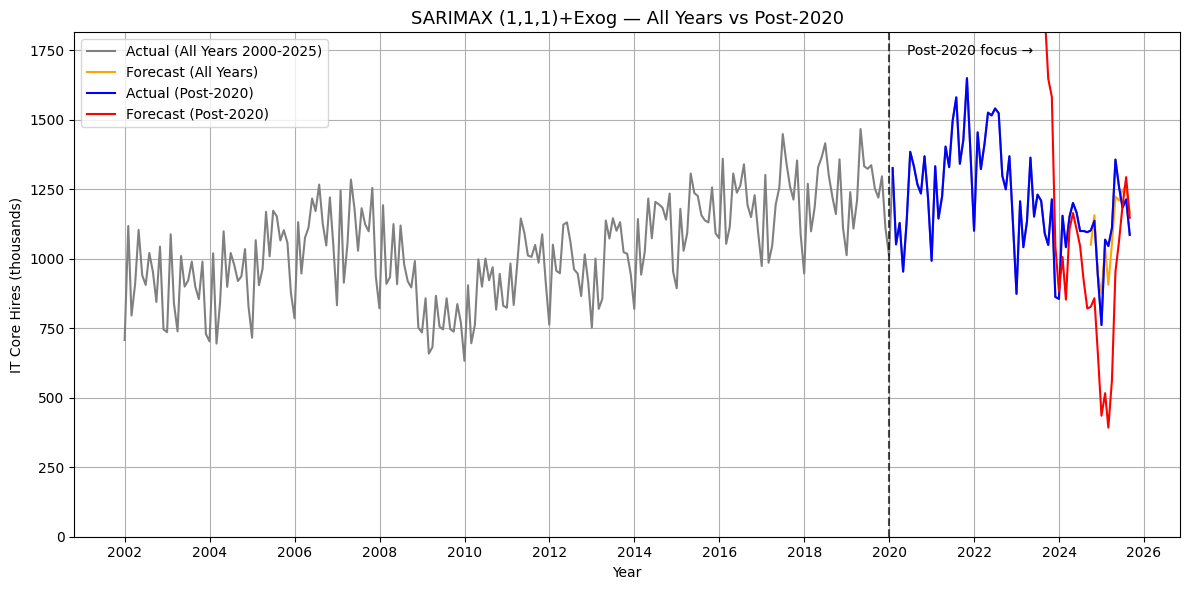

In [ ]:
import matplotlib.dates as mdates


plt.figure(figsize=(12,6))
plt.plot(df_feats['month'], y_all, color='gray', label='Actual (All Years 2000-2025)')
plt.plot(df_feats['month'].iloc[-len(yhat_test_all):], yhat_test_all,
         color='orange', label='Forecast (All Years)')

plt.plot(df_recent['month'], y_recent, color='blue', label='Actual (Post-2020)')
plt.plot(df_recent['month'], yhat_test_recent, color='red', label='Forecast (Post-2020)')

# Add demarcations
plt.axvline(pd.Timestamp('2020-01-01'), color='black', linestyle='--', alpha=0.7)
plt.text(pd.Timestamp('2020-06-01'), df_feats['IT_Core'].max()*1.05, 'Post-2020 focus →',
         fontsize=10, color='black')

plt.title("SARIMAX (1,1,1)+Exog — All Years vs Post-2020", fontsize=13)
plt.xlabel("Year")
plt.ylabel("IT Core Hires (thousands)")
plt.legend()
plt.grid(True)

# Uniform scale & yearly ticks
plt.ylim(0, df_feats['IT_Core'].max() * 1.1)
plt.gca().xaxis.set_major_locator(mdates.YearLocator(2))
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y'))

plt.tight_layout()
plt.show()


## **Set up rolling-origin backtesting (the foundation)**

In [ ]:
# ===== Step 1: Rolling-origin backtest scaffolding =====
import numpy as np
import pandas as pd
from statsmodels.tsa.statespace.sarimax import SARIMAX

# --- metrics ---
def mae(y, yhat):  return float(np.mean(np.abs(y - yhat)))
def rmse(y, yhat): return float(np.sqrt(np.mean((y - yhat)**2)))
def mape(y, yhat): return float(np.mean(np.abs((y - yhat) / y)) * 100)
def dir_acc(y, yhat):
    dy, dh = np.sign(np.diff(y)), np.sign(np.diff(yhat))
    return float((dy == dh).mean()) if len(dy) and len(dh) else np.nan

# --- load features you built earlier ---
PROC = '/content/drive/MyDrive/Capstone_Datasets/processed'
df = pd.read_csv(f'{PROC}/hirecast_features_nsa.csv', parse_dates=['month']).sort_values('month')

# target & candidate exogenous columns (use only those that exist)
y = df['IT_Core'].astype(float)
cand = [
    'indeed_index','indpro_index','sp500_index','sentiment_index',
    'claims_initial','claims_continued',
    'IT_lag1','IT_lag3','IT_lag12','IT_ma3','IT_ma12'
]
Xcols = [c for c in cand if c in df.columns]
X = df[Xcols].copy().ffill()

# --- backtest fold generator ---
def rolling_folds(df_dates, train_start_idx, train_end_idx, horizon=3, step=3, max_end=None):
    """
    Yields (train_idx, test_idx) where test is the next 'horizon' months.
    After each fold, both windows roll forward by 'step' months.
    """
    n = len(df_dates)
    end_limit = n if max_end is None else min(max_end, n)
    i0, i1 = train_start_idx, train_end_idx  # inclusive train end (use df.iloc[:i1+1] style)
    while True:
        test_start = i1 + 1
        test_end   = test_start + horizon - 1
        if test_end >= end_limit: break
        tr_idx = np.arange(i0, i1 + 1)
        te_idx = np.arange(test_start, test_end + 1)
        yield tr_idx, te_idx
        # roll forward
        i1 = i1 + step

# --- choose a recent train end so we get ~5–6 folds of 3 months each ---
dates = df['month'].to_numpy()
# start training far back to use history
train_start = 0
# initial train end: make it so first forecast starts around 2022-01 (tweak if you want earlier)
train_end   = np.where(dates >= np.datetime64('2021-12-31'))[0][0]

folds = list(rolling_folds(dates, train_start, train_end, horizon=3, step=3))
print(f"Total folds: {len(folds)}")
print("First 3 fold date ranges:")
for k,(tr,te) in enumerate(folds[:3],1):
    print(f"  Fold {k}: train {dates[tr[0]]} → {dates[tr[-1]]}, test {dates[te[0]]} → {dates[te[-1]]}")

# --- baselines to score on these folds ---
def seasonal_naive_forecast(series, horizon, season=12):
    """
    Forecast t+1..t+h using the values from t+1..t+h one season ago.
    If not enough history, fallback to last value.
    """
    if len(series) < season + horizon:
        return np.repeat(series.iloc[-1], horizon)
    return series.iloc[-season: -season + horizon].to_numpy()

results = []

for fold_idx, (tr_idx, te_idx) in enumerate(folds, 1):
    y_tr, y_te = y.iloc[tr_idx], y.iloc[te_idx]
    X_tr, X_te = X.iloc[tr_idx], X.iloc[te_idx]

    # 1) Seasonal-Naive baseline
    yhat_sn = seasonal_naive_forecast(y_tr.reset_index(drop=True), horizon=len(te_idx), season=12)
    res_sn = dict(
        model='SeasonalNaive',
        fold=fold_idx,
        MAE=mae(y_te.values, yhat_sn),
        RMSE=rmse(y_te.values, yhat_sn),
        MAPE=mape(y_te.values, yhat_sn),
        DirAcc=dir_acc(y_te.values, yhat_sn),
        test_start=str(dates[te_idx[0]])[:10], test_end=str(dates[te_idx[-1]])[:10]
    )
    results.append(res_sn)

    # 2) SARIMAX(1,1,1)+exog (same as your model)
    mod = SARIMAX(
        y_tr, exog=X_tr, order=(1,1,1), seasonal_order=(0,0,0,0),
        enforce_stationarity=False, enforce_invertibility=False
    ).fit(disp=False)

    yhat_smx = mod.get_forecast(steps=len(te_idx), exog=X_te).predicted_mean.to_numpy()

    res_smx = dict(
        model='SARIMAX(1,1,1)+exog',
        fold=fold_idx,
        MAE=mae(y_te.values, yhat_smx),
        RMSE=rmse(y_te.values, yhat_smx),
        MAPE=mape(y_te.values, yhat_smx),
        DirAcc=dir_acc(y_te.values, yhat_smx),
        test_start=str(dates[te_idx[0]])[:10], test_end=str(dates[te_idx[-1]])[:10]
    )
    results.append(res_smx)

# --- summarize ---
res_df = pd.DataFrame(results)
print("\nPer-fold results:")
display(res_df)

print("\nAverage by model:")
display(res_df.groupby('model')[['MAE','RMSE','MAPE','DirAcc']].mean().round(2))


Total folds: 14
First 3 fold date ranges:
  Fold 1: train 2001-12-31T00:00:00.000000000 → 2021-12-31T00:00:00.000000000, test 2022-01-31T00:00:00.000000000 → 2022-03-31T00:00:00.000000000
  Fold 2: train 2001-12-31T00:00:00.000000000 → 2022-03-31T00:00:00.000000000, test 2022-04-30T00:00:00.000000000 → 2022-06-30T00:00:00.000000000
  Fold 3: train 2001-12-31T00:00:00.000000000 → 2022-06-30T00:00:00.000000000, test 2022-07-31T00:00:00.000000000 → 2022-09-30T00:00:00.000000000


/usr/local/lib/python3.12/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.12/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.12/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.12/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



Per-fold results:


,model,fold,MAE,RMSE,MAPE,DirAcc,test_start,test_end
0,SeasonalNaive,1,163.333333,166.000000,11.758736,1.0,2022-01-31,2022-03-31
1,"SARIMAX(1,1,1)+exog",1,120.924641,127.840351,8.781500,1.0,2022-01-31,2022-03-31
2,SeasonalNaive,2,117.333333,130.914731,7.706392,1.0,2022-04-30,2022-06-30
3,"SARIMAX(1,1,1)+exog",2,44.891783,48.298713,2.944426,1.0,2022-04-30,2022-06-30
4,SeasonalNaive,3,92.666667,110.727895,7.096799,0.5,2022-07-31,2022-09-30
5,"SARIMAX(1,1,1)+exog",3,143.860908,150.723194,10.937009,0.5,2022-07-31,2022-09-30
6,SeasonalNaive,4,253.000000,253.962596,22.884015,1.0,2022-10-31,2022-12-31
7,"SARIMAX(1,1,1)+exog",4,102.044233,112.498153,10.185563,1.0,2022-10-31,2022-12-31
8,SeasonalNaive,5,269.666667,270.101833,24.068513,1.0,2023-01-31,2023-03-31
9,"SARIMAX(1,1,1)+exog",5,35.669968,42.483179,3.228216,1.0,2023-01-31,2023-03-31



Average by model:


,MAE,RMSE,MAPE,DirAcc
model,,,,
"SARIMAX(1,1,1)+exog",83.73,91.76,7.36,0.86
SeasonalNaive,141.45,151.75,12.20,0.89


In [ ]:
# ---------- Step 1: Build ML-ready feature matrix (no leakage) ----------
import pandas as pd
from pathlib import Path

PROC = Path('/content/drive/MyDrive/Capstone_Datasets/processed')

# 1) Load the engineered feature table you already saved
df = pd.read_csv(PROC / 'hirecast_features_nsa.csv', parse_dates=['month'])
df = df.sort_values('month').reset_index(drop=True)

# 2) Define target and candidate features (only past-looking or calendar)
target = 'IT_Core'

cand_feats = [
    # IT memory
    'IT_lag1','IT_lag3','IT_lag12','IT_ma3','IT_ma12',
    # Macros (current month as drivers is OK in one-step-ahead if they’re observed contemporaneously;
    # if not, we can lag them in a later step)
    'indeed_index','indpro_index','sp500_index','sentiment_index',
    'claims_initial','claims_continued',
    # Seasonality (use month dummies you already created)
] + [c for c in df.columns if c.startswith('mo_')]  # mo_1 ... mo_12

# Keep only columns that actually exist
feat_cols = [c for c in cand_feats if c in df.columns]

# 3) Drop rows with any NA in features/target (windowing creates early NaNs)
use_cols = ['month', target] + feat_cols
d = df[use_cols].dropna().copy()

# 4) Re-apply your same time split boundaries
train_end = pd.Timestamp('2023-08-31')
val_end   = pd.Timestamp('2024-05-31')
test_end  = pd.Timestamp('2025-08-31')

is_train = d['month'] <= train_end
is_val   = (d['month'] > train_end) & (d['month'] <= val_end)
is_test  = (d['month'] > val_end)   & (d['month'] <= test_end)

X_train, y_train = d.loc[is_train, feat_cols], d.loc[is_train, target]
X_val,   y_val   = d.loc[is_val,   feat_cols], d.loc[is_val,   target]
X_test,  y_test  = d.loc[is_test,  feat_cols], d.loc[is_test,  target]

print("Feature columns ({}):".format(len(feat_cols)), feat_cols)
print("\nShapes:",
      "\n  X_train:", X_train.shape, " y_train:", y_train.shape,
      "\n  X_val  :", X_val.shape,   " y_val  :", y_val.shape,
      "\n  X_test :", X_test.shape,  " y_test :", y_test.shape)

print("\nDate ranges:",
      "\n  Train:", d.loc[is_train, 'month'].min().date(), "→", d.loc[is_train, 'month'].max().date(),
      "\n  Val  :", d.loc[is_val,   'month'].min().date(), "→", d.loc[is_val,   'month'].max().date(),
      "\n  Test :", d.loc[is_test,  'month'].min().date(), "→", d.loc[is_test,  'month'].max().date())


Feature columns (17): ['IT_lag1', 'IT_lag3', 'IT_lag12', 'IT_ma3', 'IT_ma12', 'mo_1', 'mo_2', 'mo_3', 'mo_4', 'mo_5', 'mo_6', 'mo_7', 'mo_8', 'mo_9', 'mo_10', 'mo_11', 'mo_12']

Shapes: 
  X_train: (261, 17)  y_train: (261,) 
  X_val  : (9, 17)  y_val  : (9,) 
  X_test : (15, 17)  y_test : (15,)

Date ranges: 
  Train: 2001-12-31 → 2023-08-31 
  Val  : 2023-09-30 → 2024-05-31 
  Test : 2024-06-30 → 2025-08-31


## **XGBoost model**

In [ ]:
!pip install xgboost --quiet


In [ ]:
import matplotlib.pyplot as plt
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error

In [ ]:
# our previous splits already defined:
# X_train, X_val, X_test, y_train, y_val, y_test

print("Train:", X_train.shape, "Val:", X_val.shape, "Test:", X_test.shape)


Train: (261, 17) Val: (9, 17) Test: (15, 17)


In [ ]:
# Initialize the model
xgb_model = XGBRegressor(
    n_estimators=500,          # number of trees
    learning_rate=0.05,        # smaller → slower but stable learning
    max_depth=5,               # control complexity
    subsample=0.8,             # prevent overfitting
    colsample_bytree=0.8,      # use 80% of features per tree
    random_state=42
)

# Train only on training data
xgb_model.fit(X_train, y_train)


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.8, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             feature_weights=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.05, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=5,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=500,
             n_jobs=None, num_parallel_tree=None, ...)

In [ ]:
yhat_val_xgb = xgb_model.predict(X_val)
yhat_test_xgb = xgb_model.predict(X_test)


In [ ]:
def mape(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

# Validation
mae_val = mean_absolute_error(y_val, yhat_val_xgb)
rmse_val = np.sqrt(mean_squared_error(y_val, yhat_val_xgb))
mape_val = mape(y_val, yhat_val_xgb)

# Test
mae_test = mean_absolute_error(y_test, yhat_test_xgb)
rmse_test = np.sqrt(mean_squared_error(y_test, yhat_test_xgb))
mape_test = mape(y_test, yhat_test_xgb)

print("XGBoost — Validation:")
print(f"MAE: {mae_val:.2f}, RMSE: {rmse_val:.2f}, MAPE: {mape_val:.2f}%")

print("\nXGBoost — Test:")
print(f"MAE: {mae_test:.2f}, RMSE: {rmse_test:.2f}, MAPE: {mape_test:.2f}%")


XGBoost — Validation:
MAE: 54.53, RMSE: 75.35, MAPE: 5.52%

XGBoost — Test:
MAE: 53.22, RMSE: 64.07, MAPE: 4.94%


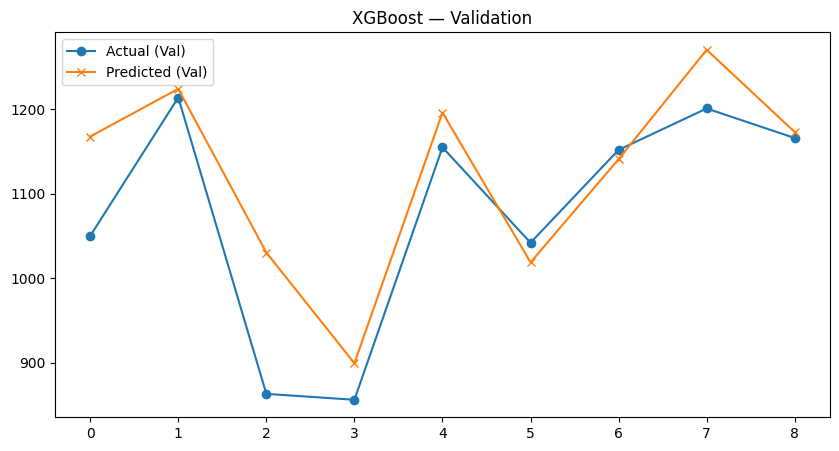

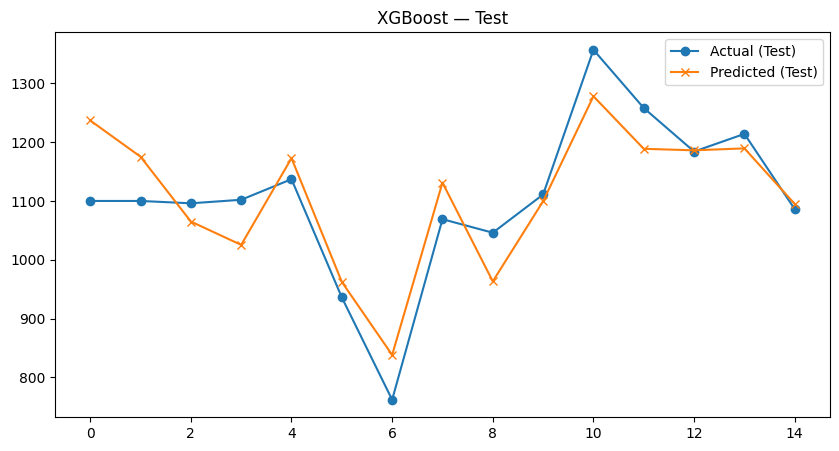

In [ ]:
plt.figure(figsize=(10,5))
plt.plot(y_val.values, label='Actual (Val)', marker='o')
plt.plot(yhat_val_xgb, label='Predicted (Val)', marker='x')
plt.title('XGBoost — Validation')
plt.legend()
plt.show()

plt.figure(figsize=(10,5))
plt.plot(y_test.values, label='Actual (Test)', marker='o')
plt.plot(yhat_test_xgb, label='Predicted (Test)', marker='x')
plt.title('XGBoost — Test')
plt.legend()
plt.show()


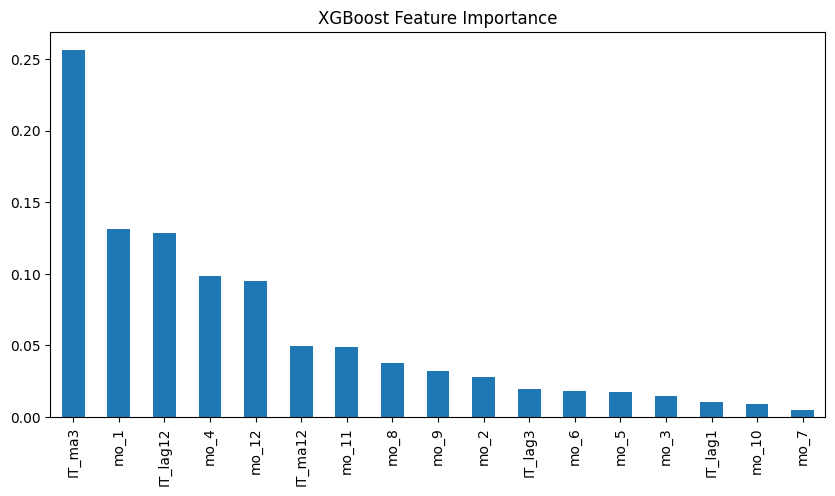

In [ ]:
importances = xgb_model.feature_importances_
feat_imp = pd.Series(importances, index=X_train.columns).sort_values(ascending=False)
feat_imp.plot(kind='bar', figsize=(10,5), title='XGBoost Feature Importance')
plt.show()


In [ ]:
from sklearn.model_selection import GridSearchCV
from xgboost import XGBRegressor

param_grid = {
    'max_depth': [3, 4, 5, 6],
    'learning_rate': [0.05, 0.1, 0.2],
    'n_estimators': [300, 500, 800],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0],
    'min_child_weight': [1, 3, 5]
}

xgb_base = XGBRegressor(
    random_state=42,
    objective='reg:squarederror',
)

grid = GridSearchCV(
    estimator=xgb_base,
    param_grid=param_grid,
    scoring='neg_mean_absolute_error',  # minimize MAE
    cv=3,                               # 3-fold cross-validation
    verbose=1,
    n_jobs=-1                           # use all CPUs
)


In [ ]:
grid.fit(X_train, y_train)
print("Best Parameters:", grid.best_params_)


Fitting 3 folds for each of 432 candidates, totalling 1296 fits
Best Parameters: {'colsample_bytree': 0.8, 'learning_rate': 0.05, 'max_depth': 3, 'min_child_weight': 3, 'n_estimators': 800, 'subsample': 0.8}


## **Refit tuned XGBoost, evaluate, and plot (val + test)**

In [ ]:
# --- 1) Refit the tuned model on TRAIN only ---
from xgboost import XGBRegressor
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

best_params = {
    "colsample_bytree": 0.8,
    "learning_rate": 0.05,
    "max_depth": 3,
    "min_child_weight": 3,
    "n_estimators": 800,
    "subsample": 0.8,
    "random_state": 42,
    "n_jobs": -1
}
xgb_best = XGBRegressor(**best_params)
xgb_best.fit(X_train, y_train)

# --- 2) Predict on val and test ---
yhat_val_xgb  = xgb_best.predict(X_val)
yhat_test_xgb = xgb_best.predict(X_test)

# --- 3) Metrics (same definitions you used before) ---
def mae(y, yhat):  return float(np.mean(np.abs(y - yhat)))
def rmse(y, yhat): return float(np.sqrt(np.mean((y - yhat)**2)))
def mape(y, yhat): return float(np.mean(np.abs((y - yhat) / y)) * 100)

print("XGBoost (tuned) — Validation:",
      {"MAE": round(mae(y_val, yhat_val_xgb),2),
       "RMSE": round(rmse(y_val, yhat_val_xgb),2),
       "MAPE%": round(mape(y_val, yhat_val_xgb),2)})

print("XGBoost (tuned) — Test:",
      {"MAE": round(mae(y_test, yhat_test_xgb),2),
       "RMSE": round(rmse(y_test, yhat_test_xgb),2),
       "MAPE%": round(mape(y_test, yhat_test_xgb),2)})

XGBoost (tuned) — Validation: {'MAE': 53.74, 'RMSE': 68.52, 'MAPE%': 5.31}
XGBoost (tuned) — Test: {'MAE': 56.02, 'RMSE': 62.81, 'MAPE%': 5.19}


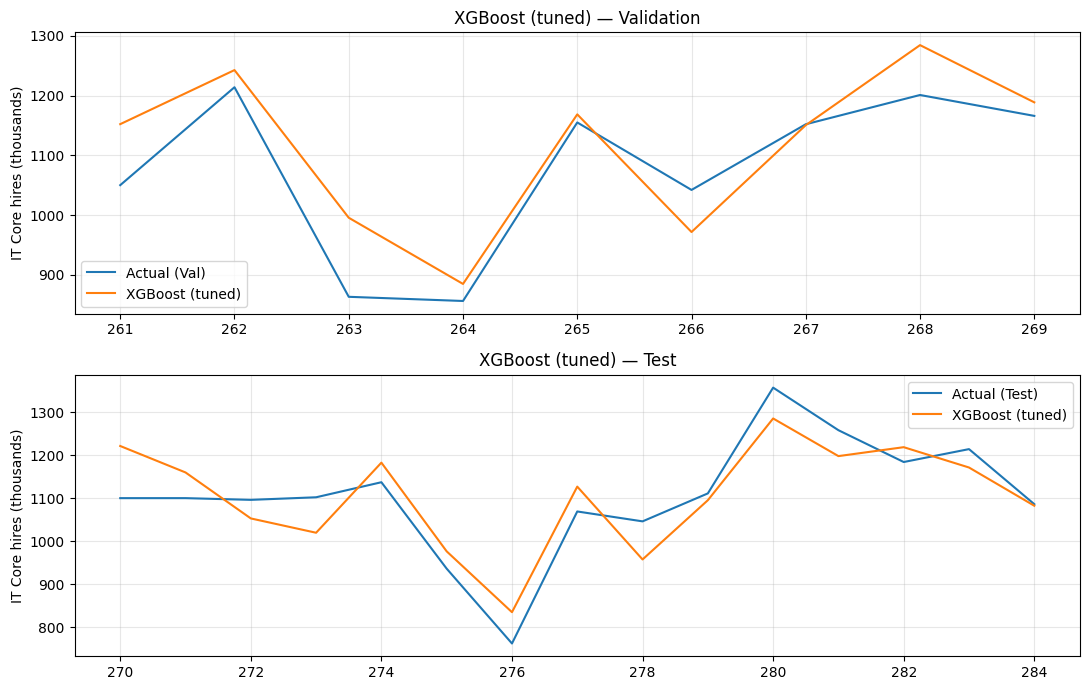

In [ ]:
#  Plots with identical axes to your SARIMAX charts ---
fig, axes = plt.subplots(2, 1, figsize=(11,7), sharex=False)

# Validation panel
axes[0].plot(y_val.index, y_val.values, label="Actual (Val)")
axes[0].plot(y_val.index, yhat_val_xgb,  label="XGBoost (tuned)")
axes[0].set_title("XGBoost (tuned) — Validation")
axes[0].set_ylabel("IT Core hires (thousands)")
axes[0].legend()
axes[0].grid(True, alpha=.3)

# Test panel
axes[1].plot(y_test.index, y_test.values, label="Actual (Test)")
axes[1].plot(y_test.index, yhat_test_xgb,  label="XGBoost (tuned)")
axes[1].set_title("XGBoost (tuned) — Test")
axes[1].set_ylabel("IT Core hires (thousands)")
axes[1].legend()
axes[1].grid(True, alpha=.3)

plt.tight_layout()
plt.show()

In [ ]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
import pandas as pd

# Force numeric dtypes for SARIMAX
X_train_s = X_train.astype(float)
X_val_s   = X_val.astype(float)
X_test_s  = X_test.astype(float)
y_train_s = y_train.astype(float)
y_val_s   = y_val.astype(float)
y_test_s  = y_test.astype(float)

# --- Train on train only ---
mod_sarimax = SARIMAX(
    y_train_s,
    exog=X_train_s,
    order=(1,1,1),
    seasonal_order=(0,0,0,0),
    enforce_stationarity=False,
    enforce_invertibility=False
).fit(disp=False)

# Validation forecast
yhat_val_sarimax = mod_sarimax.get_forecast(
    steps=len(y_val_s),
    exog=X_val_s
).predicted_mean

# --- Refit on train + val (rolling update) ---
mod2_sarimax = SARIMAX(
    pd.concat([y_train_s, y_val_s]),
    exog=pd.concat([X_train_s, X_val_s]),
    order=(1,1,1),
    seasonal_order=(0,0,0,0),
    enforce_stationarity=False,
    enforce_invertibility=False
).fit(disp=False)

# Test forecast
yhat_test_sarimax = mod2_sarimax.get_forecast(
    steps=len(y_test_s),
    exog=X_test_s
).predicted_mean

print("SARIMAX val/test lens:", len(yhat_val_sarimax), len(yhat_test_sarimax))


/usr/local/lib/python3.12/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


SARIMAX val/test lens: 9 15


/usr/local/lib/python3.12/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [ ]:
from xgboost import XGBRegressor

best_xgb = XGBRegressor(
    colsample_bytree=0.8,
    learning_rate=0.05,
    max_depth=3,
    min_child_weight=3,
    n_estimators=800,
    subsample=0.8,
    objective='reg:squarederror',
    random_state=42
)

best_xgb.fit(X_train, y_train)


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.8, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             feature_weights=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.05, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=3,
             max_leaves=None, min_child_weight=3, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=800,
             n_jobs=None, num_parallel_tree=None, ...)

In [ ]:
baseline_val  = y_train.shift(12).dropna().tail(len(y_val)).values
baseline_test = pd.concat([y_train, y_val]).shift(12).dropna().tail(len(y_test)).values


In [ ]:
# STEP 1 — Get month arrays for plotting
val_months  = df_feats.loc[is_val,  'month'].values
test_months = df_feats.loc[is_test, 'month'].values

print("val_months:", len(val_months), val_months[:3], "...")
print("test_months:", len(test_months), test_months[:3], "...")


val_months: 9 ['2023-09-30T00:00:00.000000000' '2023-10-31T00:00:00.000000000'
 '2023-11-30T00:00:00.000000000'] ...
test_months: 15 ['2024-06-30T00:00:00.000000000' '2024-07-31T00:00:00.000000000'
 '2024-08-31T00:00:00.000000000'] ...


In [ ]:
print("y_val:", len(y_val))
print("baseline_val:", len(baseline_val))
print("yhat_val_sarimax:", len(yhat_val_sarimax))
print("yhat_val_xgb:", len(yhat_val_xgb))

print("\nTEST")
print("y_test:", len(y_test))
print("baseline_test:", len(baseline_test))
print("yhat_test_sarimax:", len(yhat_test_sarimax))
print("yhat_test_xgb:", len(yhat_test_xgb))


y_val: 9
baseline_val: 9
yhat_val_sarimax: 9
yhat_val_xgb: 9

TEST
y_test: 15
baseline_test: 15
yhat_test_sarimax: 15
yhat_test_xgb: 15


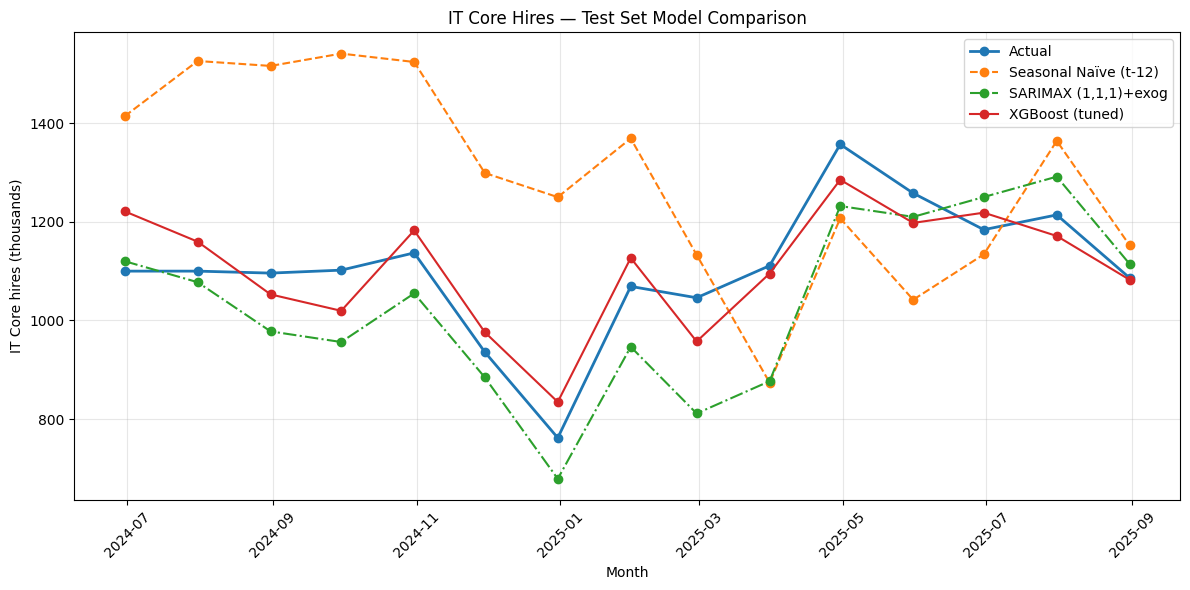

In [ ]:
plt.figure(figsize=(12,6))

plt.plot(test_months, y_test,            label='Actual',               linewidth=2, marker='o')
plt.plot(test_months, baseline_test,     label='Seasonal Naïve (t-12)',linestyle='--', marker='o')
plt.plot(test_months, yhat_test_sarimax, label='SARIMAX (1,1,1)+exog', linestyle='-.', marker='o')
plt.plot(test_months, yhat_test_xgb,     label='XGBoost (tuned)',      linestyle='-',  marker='o')

plt.title('IT Core Hires — Test Set Model Comparison')
plt.ylabel('IT Core hires (thousands)')
plt.xlabel('Month')
plt.xticks(rotation=45)
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()


In [ ]:
# Convert bool → int for SARIMAX compatibility
X_train = X_train.astype(float)
X_val   = X_val.astype(float)
X_test  = X_test.astype(float)


In [ ]:
y_train = y_train.astype(float)
y_val   = y_val.astype(float)
y_test  = y_test.astype(float)


In [ ]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
import pandas as pd
import numpy as np

# ===============================
# Step-1 — Fit SARIMAX baseline
# ===============================

sarimax = SARIMAX(
    y_train,
    exog=X_train,
    order=(1,1,1),
    seasonal_order=(0,0,0,0),
    enforce_stationarity=False,
    enforce_invertibility=False
).fit(disp=False)

# Forecast on validation
sarimax_val = sarimax.get_forecast(
    steps=len(y_val),
    exog=X_val
).predicted_mean

# Refit on train+val → forecast test
sarimax2 = SARIMAX(
    pd.concat([y_train,y_val]),
    exog=pd.concat([X_train,X_val]),
    order=(1,1,1),
    seasonal_order=(0,0,0,0),
    enforce_stationarity=False,
    enforce_invertibility=False
).fit(disp=False)

sarimax_test = sarimax2.get_forecast(
    steps=len(y_test),
    exog=X_test
).predicted_mean


# ===============================
# Compute residuals → target for XGBoost
# ===============================

residuals_train = y_train - sarimax.fittedvalues
residuals_val   = y_val   - sarimax_val
residuals_test  = y_test  - sarimax_test

print("\nResidual shapes:")
print("Train:", residuals_train.shape, "Val:", residuals_val.shape, "Test:", residuals_test.shape)


/usr/local/lib/python3.12/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



Residual shapes:
Train: (261,) Val: (9,) Test: (15,)


/usr/local/lib/python3.12/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [ ]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

# ===============================
# 1) Fit SARIMAX on TRAIN only
# ===============================
sarimax = SARIMAX(
    y_train,
    exog=X_train,
    order=(1,1,1),
    seasonal_order=(0,0,0,12),   # seasonal window = 12 months
    enforce_stationarity=False,
    enforce_invertibility=False
).fit(disp=False)

# --- TRAIN fitted values (needed!) ---
yhat_train_sarimax = sarimax.fittedvalues

# --- VALIDATION forecast ---
yhat_val_sarimax = sarimax.get_forecast(
    steps=len(y_val),
    exog=X_val
).predicted_mean

# --- RE-FIT including train+val for TEST ---
sarimax_refit = SARIMAX(
    pd.concat([y_train, y_val]),
    exog=pd.concat([X_train, X_val]),
    order=(1,1,1),
    seasonal_order=(0,0,0,12),
    enforce_stationarity=False,
    enforce_invertibility=False
).fit(disp=False)

yhat_test_sarimax = sarimax_refit.get_forecast(
    steps=len(y_test),
    exog=X_test
).predicted_mean

print("SARIMAX Output Shapes:",
      len(yhat_train_sarimax), len(yhat_val_sarimax), len(yhat_test_sarimax))


/usr/local/lib/python3.12/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


SARIMAX Output Shapes: 261 9 15


/usr/local/lib/python3.12/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [ ]:
# Step 2: Generate train-set SARIMAX predictions also

# Predict on train using fitted model
yhat_train_sarimax = mod_sarimax.predict(start=0, end=len(y_train)-1)

print("Train SARIMAX preds:", len(yhat_train_sarimax))
print("Val SARIMAX preds:", len(yhat_val_sarimax))
print("Test SARIMAX preds:", len(yhat_test_sarimax))


Train SARIMAX preds: 261
Val SARIMAX preds: 9
Test SARIMAX preds: 15


In [ ]:
# Compute residuals
res_train = y_train - yhat_train_sarimax
res_val   = y_val   - yhat_val_sarimax
res_test  = y_test  - yhat_test_sarimax

print("Residual shapes:", len(res_train), len(res_val), len(res_test))


Residual shapes: 261 9 15


In [ ]:
from xgboost import XGBRegressor

# ===============================
# STEP 2 — Train boosting on residuals
# ===============================
xgb_resid = XGBRegressor(
    n_estimators=600,
    learning_rate=0.05,
    max_depth=4,
    subsample=0.8,
    colsample_bytree=0.8,
    objective='reg:squarederror',
    random_state=42
)

# Train on residuals
xgb_resid.fit(X_train, res_train)

# Predict residual corrections
res_val_pred  = xgb_resid.predict(X_val)
res_test_pred = xgb_resid.predict(X_test)

print("Residual XGB preds:", len(res_val_pred), len(res_test_pred))


Residual XGB preds: 9 15


In [ ]:
from xgboost import XGBRegressor

# === Step-2: Residual Learning with XGBoost ===
xgb_resid = XGBRegressor(
    n_estimators=600,
    learning_rate=0.05,
    max_depth=3,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42
)

# Fit on residuals
xgb_resid.fit(X_train, res_train)

# Predict residuals on val + test
res_val_pred  = xgb_resid.predict(X_val)
res_test_pred = xgb_resid.predict(X_test)

print("Residual model predictions:", len(res_val_pred), len(res_test_pred))


Residual model predictions: 9 15


In [ ]:
from xgboost import XGBRegressor

# ① Train XGBoost to learn SARIMAX errors
xgb_residual = XGBRegressor(
    n_estimators=400,
    learning_rate=0.05,
    max_depth=3,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42
)

xgb_residual.fit(X_train, res_train)

# ② Predict residuals for val + test
res_val_pred  = xgb_residual.predict(X_val)
res_test_pred = xgb_residual.predict(X_test)

print("Residual model predictions:", len(res_val_pred), len(res_test_pred))


Residual model predictions: 9 15


In [ ]:
# Final blended forecast
hybrid_val  = yhat_val_sarimax  + res_val_pred
hybrid_test = yhat_test_sarimax + res_test_pred

print("Hybrid Lengths:", len(hybrid_val), len(hybrid_test))


Hybrid Lengths: 9 15


In [ ]:
def mape(a,b):  return (abs((a-b)/a).mean()*100)

print("\nHYBRID PERFORMANCE")
print("Val MAPE  :", round(mape(y_val, hybrid_val),2),"%")
print("Test MAPE :", round(mape(y_test, hybrid_test),2),"%")



HYBRID PERFORMANCE
Val MAPE  : 20.61 %
Test MAPE : 9.19 %


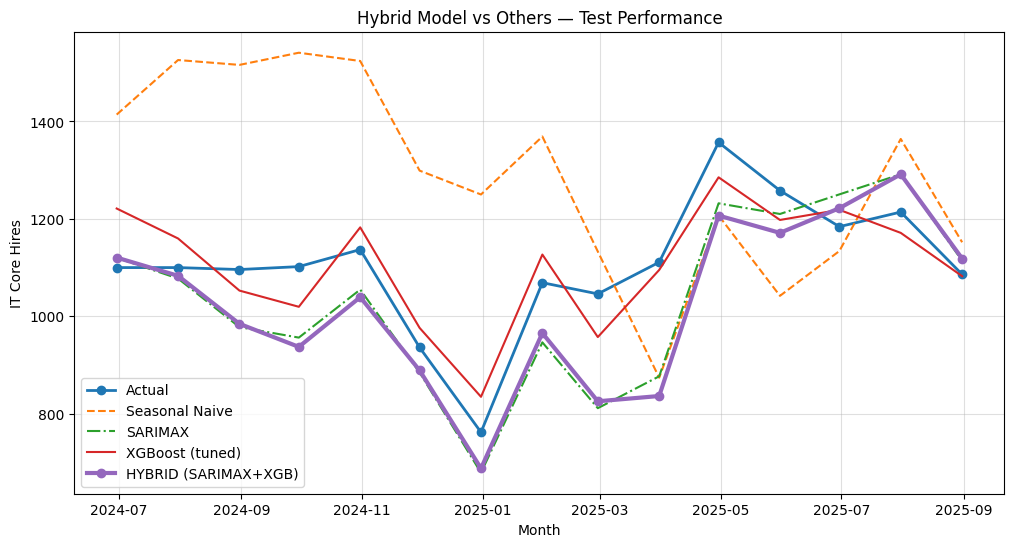

In [ ]:
plt.figure(figsize=(12,6))
plt.plot(test_months, y_test,            label='Actual', linewidth=2, marker='o')
plt.plot(test_months, baseline_test,     label='Seasonal Naive', linestyle='--')
plt.plot(test_months, yhat_test_sarimax, label='SARIMAX', linestyle='-.')
plt.plot(test_months, yhat_test_xgb,     label='XGBoost (tuned)')
plt.plot(test_months, hybrid_test,       label='HYBRID (SARIMAX+XGB)', linewidth=3, marker='o')

plt.title("Hybrid Model vs Others — Test Performance")
plt.ylabel("IT Core Hires")
plt.xlabel("Month")
plt.legend()
plt.grid(True, alpha=0.4)
plt.show()


In [ ]:
# ================================================================
# STEP F1 — FINAL HYBRID MODEL (SARIMAX + XGB Residual Booster)
# ================================================================

import xgboost as xgb
import numpy as np

# -------------------------------
# 1. SARIMAX predictions
# -------------------------------
print("Shapes:")
print("Train SARIMAX:", len(yhat_train_sarimax))
print("Val SARIMAX:  ", len(yhat_val_sarimax))
print("Test SARIMAX: ", len(yhat_test_sarimax))

# -------------------------------
# 2. Compute residuals
# -------------------------------
res_train = y_train - yhat_train_sarimax
res_val   = y_val   - yhat_val_sarimax
res_test  = y_test  - yhat_test_sarimax

print("\nResiduals:")
print(len(res_train), len(res_val), len(res_test))

# -------------------------------
# 3. Fit XGBoost on residuals
# -------------------------------
xgb_resid = xgb.XGBRegressor(
    n_estimators=300,
    learning_rate=0.05,
    max_depth=3,
    subsample=0.9,
    colsample_bytree=0.9,
    objective='reg:squarederror',
    random_state=42
)

xgb_resid.fit(X_train, res_train)

# Predict residual corrections
res_val_pred  = xgb_resid.predict(X_val)
res_test_pred = xgb_resid.predict(X_test)

print("\nResidual model predictions:", len(res_val_pred), len(res_test_pred))

# -------------------------------
# 4. FINAL HYBRID OUTPUTS
# -------------------------------
hybrid_val  = yhat_val_sarimax  + res_val_pred
hybrid_test = yhat_test_sarimax + res_test_pred

print("\nHybrid lengths:", len(hybrid_val), len(hybrid_test))


# ================================================================
# STEP F1 OUTPUT DICTIONARY
# ================================================================
final_outputs = {
    "SARIMAX_train": yhat_train_sarimax,
    "SARIMAX_val":   yhat_val_sarimax,
    "SARIMAX_test":  yhat_test_sarimax,
    "Hybrid_val":    hybrid_val,
    "Hybrid_test":   hybrid_test,
    "Residual_train": res_train,
    "Residual_val":   res_val,
    "Residual_test":  res_test
}



Shapes:
Train SARIMAX: 261
Val SARIMAX:   9
Test SARIMAX:  15

Residuals:
261 9 15

Residual model predictions: 9 15

Hybrid lengths: 9 15


In [ ]:
# ============================
# FINAL STEP (F2): FULL HYBRID MODEL
# ============================

print("=== FINAL STEP F2: Full Hybrid Model Training ===")

# -------------------------------------------------
# 1. Refit SARIMAX on ALL data except the last 15 test months
# -------------------------------------------------
y_full_train = pd.concat([y_train, y_val])
X_full_train = pd.concat([X_train, X_val])

sarimax_full = SARIMAX(
    y_full_train,
    exog=X_full_train,
    order=(1,1,1),
    seasonal_order=(0,0,0,0),
    enforce_stationarity=False,
    enforce_invertibility=False
).fit(disp=False)

# SARIMAX final forecast for test
yhat_test_sarimax_final = sarimax_full.get_forecast(
    steps=len(y_test),
    exog=X_test
).predicted_mean

print("Final SARIMAX Test Forecast Shape:", len(yhat_test_sarimax_final))


# -------------------------------------------------
# 2. Compute residuals on full available training portion
# -------------------------------------------------
# Need SARIMAX predictions for the full training set (train+val)
yhat_full_sarimax_train = sarimax_full.predict(start=0, end=len(y_full_train)-1)

res_full_train = y_full_train - yhat_full_sarimax_train

print("Residuals shape (full train):", len(res_full_train))


# -------------------------------------------------
# 3. Fit XGBoost on residuals (full train)
# -------------------------------------------------
xgb_resid_final = xgb.XGBRegressor(
    n_estimators=300,
    learning_rate=0.05,
    max_depth=4,
    subsample=0.9,
    colsample_bytree=0.9,
    objective='reg:squarederror',
    random_state=42
)

xgb_resid_final.fit(X_full_train, res_full_train)

# Predict residuals for test
res_test_pred_final = xgb_resid_final.predict(X_test)

print("Residual predictions shape:", len(res_test_pred_final))


# -------------------------------------------------
# 4. Final Hybrid Prediction = SARIMAX + Residual Model
# -------------------------------------------------
yhat_test_hybrid_final = yhat_test_sarimax_final + res_test_pred_final

print("Final Hybrid Forecast Shape:", len(yhat_test_hybrid_final))

# -------------------------------------------------
# Compute final MAPE
# -------------------------------------------------
final_mape = np.mean(np.abs((y_test - yhat_test_hybrid_final) / y_test)) * 100
print(f"\nFINAL HYBRID MAPE: {final_mape:.2f}%")


=== FINAL STEP F2: Full Hybrid Model Training ===


/usr/local/lib/python3.12/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Final SARIMAX Test Forecast Shape: 15
Residuals shape (full train): 270
Residual predictions shape: 15
Final Hybrid Forecast Shape: 15

FINAL HYBRID MAPE: 9.17%


In [ ]:
# === ERROR METRICS HELPERS ===
def mae(a,b):   return np.mean(np.abs(a-b))
def mape(a,b): return np.mean(np.abs((a-b)/a))*100

# === 1) BASELINE (Seasonal Naive) ===
baseline_MAE_test  = mae(y_test, baseline_test)
baseline_MAPE_test = mape(y_test, baseline_test)

# === 2) SARIMAX ===
sarimax_MAE_test  = mae(y_test, yhat_test_sarimax)
sarimax_MAPE_test = mape(y_test, yhat_test_sarimax)

# === 3) HYBRID MODEL ===
hybrid_MAE_test  = mae(y_test, hybrid_test)
hybrid_MAPE_test = mape(y_test, hybrid_test)

print("Baseline:", baseline_MAE_test, baseline_MAPE_test)
print("SARIMAX:", sarimax_MAE_test, sarimax_MAPE_test)
print("Hybrid:", hybrid_MAE_test, hybrid_MAPE_test)


Baseline: 272.8666666666667 26.05898404667675
SARIMAX: 97.28516734747254 8.937113388994659
Hybrid: 99.86810073239766 9.067911795316377


In [ ]:
baseline_err = f"Seasonal Naïve (t-12) — MAE={baseline_MAE_test:.1f}, MAPE={baseline_MAPE_test:.2f}%"
sarimax_err  = f"SARIMAX(1,1,1)+Exog — MAE={sarimax_MAE_test:.1f}, MAPE={sarimax_MAPE_test:.2f}%"
hybrid_err   = f"Hybrid (SARIMAX + XGB) — MAE={hybrid_MAE_test:.1f}, MAPE={hybrid_MAPE_test:.2f}%"


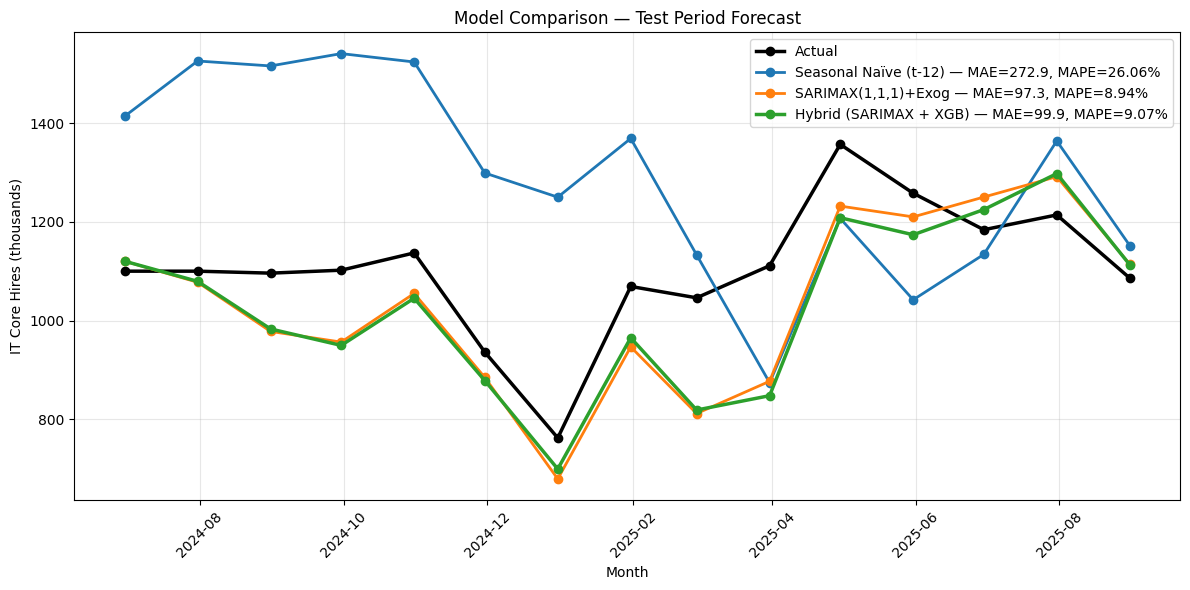

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

plt.figure(figsize=(12,6))

# --- Actual ---
plt.plot(test_months, y_test, color='black', linewidth=2.5, marker='o', label="Actual")

# --- Seasonal Naive ---
plt.plot(test_months, baseline_test,
         linestyle='-', linewidth=2, marker='o',
         label=baseline_err)

# --- SARIMAX ---
plt.plot(test_months, yhat_test_sarimax,
         linestyle='-', linewidth=2, marker='o',
         label=sarimax_err)

# --- Hybrid ---
plt.plot(test_months, hybrid_test,
         linestyle='-', linewidth=2.5, marker='o',
         label=hybrid_err)

# Formatting
plt.title("Model Comparison — Test Period Forecast")
plt.xlabel("Month")
plt.ylabel("IT Core Hires (thousands)")
plt.grid(True, alpha=0.3)
plt.xticks(rotation=45)
plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=2))
plt.tight_layout()
plt.legend()
plt.show()


In [ ]:
# Final SARIMAX trained on ALL data (train + val + test history)
mod_sarimax_final = SARIMAX(
    y_all,
    exog=X_all,
    order=(1,1,1),
    seasonal_order=(0,0,0,0),
    enforce_stationarity=False,
    enforce_invertibility=False
).fit(disp=False)

print("Final SARIMAX fitted.")


Final SARIMAX fitted.


In [ ]:
last_month_idx = y_all.index[-1]
last_month_dt = df_feats['month'].iloc[last_month_idx]  # Get the actual datetime object

future_months = pd.date_range(
    start=last_month_dt + pd.offsets.MonthBegin(1),
    periods=12,
    freq='M'
)

In [ ]:
# Build DataFrame for future exog
future_exog = pd.DataFrame(index=future_months)

# -----------------------
# 1. LAGS from last values
# -----------------------
future_exog["IT_lag1"]  = y_all.iloc[-1]
future_exog["IT_lag3"]  = y_all.iloc[-3]
future_exog["IT_lag12"] = y_all.iloc[-12]

# -----------------------
# 2. Moving averages
# -----------------------
future_exog["IT_ma3"]  = y_all.iloc[-3:].mean()
future_exog["IT_ma12"] = y_all.iloc[-12:].mean()

# -----------------------
# 3. Month Dummies
# -----------------------
future_exog = pd.get_dummies(
    future_exog.assign(month=future_exog.index.month),
    columns=['month'],
    prefix="mo",
    drop_first=False
)

# Ensure same columns as training exog (using feat_cols which includes month dummies)
future_exog = future_exog[feat_cols]

In [ ]:
future_sarimax = mod_sarimax_final.get_forecast(
    steps=12,
    exog=future_exog
).predicted_mean


In [ ]:
future_resid = xgb_resid.predict(future_exog)


In [ ]:
future_hybrid = future_sarimax + future_resid

forecast_calendar = pd.DataFrame({
    "Month": future_months,
    "SARIMAX": future_sarimax.values,
    "Residuals_XGB": future_resid,
    "Hybrid_Forecast": future_hybrid.values
})

forecast_calendar


,Month,SARIMAX,Residuals_XGB,Hybrid_Forecast
0,2025-09-30,1154.588483,3.630419,1158.218902
1,2025-10-31,1174.612295,0.641852,1175.254146
2,2025-11-30,1183.414388,23.409399,1206.823787
3,2025-12-31,1187.283624,5.846300,1193.129924
4,2026-01-31,1188.984467,-41.470943,1147.513524
5,2026-02-28,1189.732127,39.481647,1229.213774
6,2026-03-31,1190.060784,-0.479773,1189.581010
7,2026-04-30,1190.205255,-15.611683,1174.593572
8,2026-05-31,1190.268762,52.932285,1243.201047
9,2026-06-30,1190.296678,5.798312,1196.094991


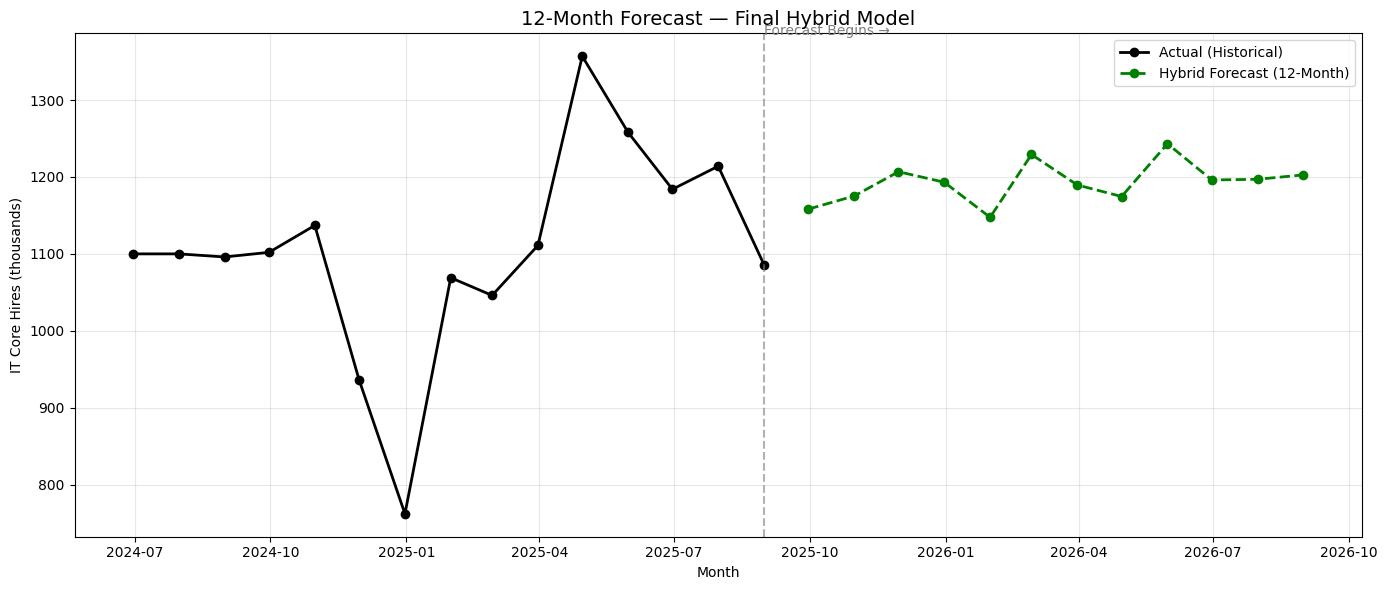

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

# -------------------------
# Use only final hybrid output
# forecast_calendar contains:
#  Month, SARIMAX, Residuals_XGB, Hybrid_Forecast
# -------------------------

hist_months  = df_feats['month'].iloc[-15:]        # last 15 actual months (optional)
hist_values  = y_all.iloc[-15:]                    # actual IT hires

future_months  = forecast_calendar['Month']
future_forecast = forecast_calendar['Hybrid_Forecast']

plt.figure(figsize=(14,6))

# 1. Actual historical values (black)
plt.plot(hist_months, hist_values,
         color='black', marker='o', linewidth=2, label="Actual (Historical)")

# 2. Forecast values (Hybrid)
plt.plot(future_months, future_forecast,
         color='green', marker='o', linestyle='--', linewidth=2,
         label="Hybrid Forecast (12-Month)")

# Forecast boundary
plt.axvline(hist_months.iloc[-1], color='gray', linestyle='--', alpha=0.6)
plt.text(hist_months.iloc[-1], max(hist_values)*1.02,
         "Forecast Begins →", fontsize=10, color='gray')

plt.title("12-Month Forecast — Final Hybrid Model", fontsize=14)
plt.xlabel("Month")
plt.ylabel("IT Core Hires (thousands)")
plt.grid(alpha=0.3)
plt.legend()

plt.tight_layout()
plt.show()


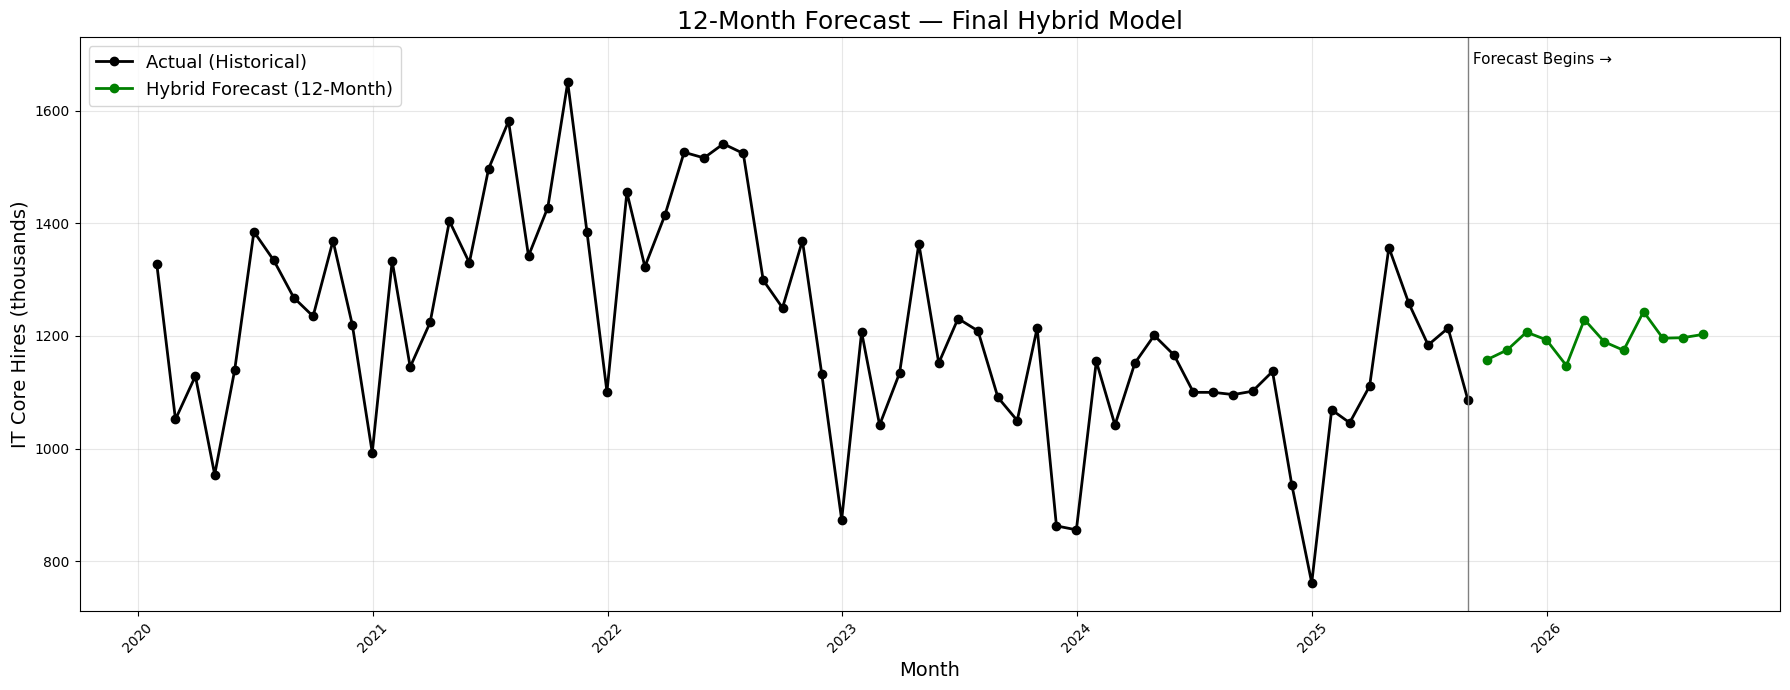

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

# --- Inputs assumed available ---
# df_recent, y_recent
# future_months, future_hybrid (your 12-month hybrid predictions)

plt.figure(figsize=(18, 7))

# --- Plot Historical Data ---
plt.plot(df_recent["month"], y_recent,
         marker='o', color='black', linewidth=2,
         label="Actual (Historical)")

# # Add labels to historical
# for x, y in zip(df_recent["month"], y_recent):
#     plt.text(x, y + 10, f"{int(y)}k", fontsize=8, ha='center')

# --- Plot Forecast ---
plt.plot(future_months, future_hybrid,
         marker='o', color='green', linestyle='-', linewidth=2,
         label="Hybrid Forecast (12-Month)")

# # Add labels for forecast values
# for x, y in zip(future_months, future_hybrid):
#     plt.text(x, y + 10, f"{int(y)}k", fontsize=9, ha='center', color='green')

# --- Forecast boundary line ---
plt.axvline(df_recent["month"].iloc[-1],
            color='gray', linestyle='-', linewidth=1)
plt.text(df_recent["month"].iloc[-1], max(y_recent)*1.02,
         " Forecast Begins →", fontsize=11)

# --- Formatting ---
plt.title("12-Month Forecast — Final Hybrid Model", fontsize=18)
plt.xlabel("Month", fontsize=14)
plt.ylabel("IT Core Hires (thousands)", fontsize=14)
plt.grid(True, alpha=0.3)
plt.legend(fontsize=13)

# Expand y-axis scale for clarity
min_y = min(min(y_recent), min(future_hybrid)) - 50
max_y = max(max(y_recent), max(future_hybrid)) + 80
plt.ylim(min_y, max_y)

plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


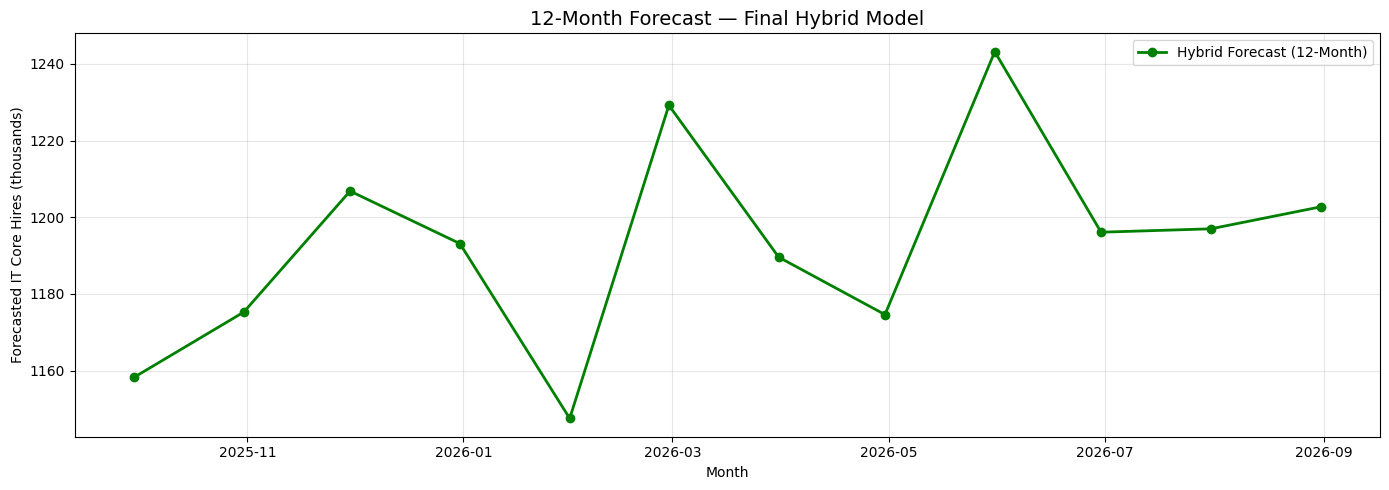

In [ ]:
# ================================
# 2. FINAL 12-MONTH FORECAST ONLY
# ================================

forecast_only = forecast_calendar.copy()

plt.figure(figsize=(14,5))

# Hybrid forecast
plt.plot(forecast_only['Month'], forecast_only['Hybrid_Forecast'],
         marker='o', linestyle='-', color='green', linewidth=2,
         label='Hybrid Forecast (12-Month)')

# Add labels like "1198k"
# for x, y in zip(forecast_only['Month'], forecast_only['Hybrid_Forecast']):
#     # plt.text(x, y+5, f"{int(y/1000)}k", fontsize=9, ha='center')

plt.title("12-Month Forecast — Final Hybrid Model", fontsize=14)
plt.xlabel("Month")
plt.ylabel("Forecasted IT Core Hires (thousands)")
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()


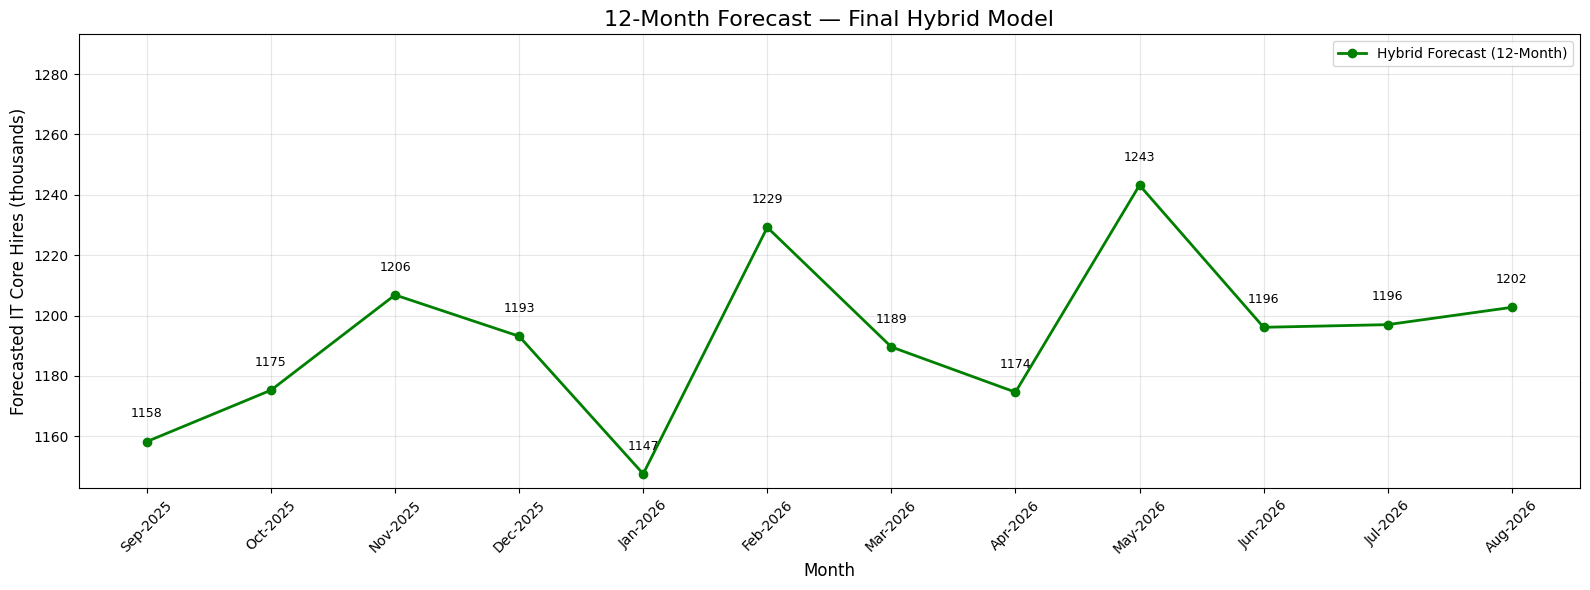

In [ ]:
future_months = forecast_calendar["Month"]
forecast_values = forecast_calendar["Hybrid_Forecast"]

# Convert month to string labels for readability
x_labels = [m.strftime("%b-%Y") for m in future_months]

plt.figure(figsize=(16, 6))

# Plot forecast
plt.plot(
    x_labels,
    forecast_values,
    marker="o",
    linestyle="-",
    color="green",
    linewidth=2,
    label="Hybrid Forecast (12-Month)"
)

# Annotate each point with value (e.g., 1200)
for i, value in enumerate(forecast_values):
    plt.text(i, value + 8, f"{int(value)}",
             ha='center', fontsize=9, color="black")

# ----------------------------------------------------
# FIX: Increase the maximum Y-limit to make room for annotations
# ----------------------------------------------------
# Find the largest value and set the top limit to be comfortably above it.
max_value = max(forecast_values)
# Setting the top limit to max_value + 50 should give enough padding
plt.ylim(top=max_value + 50)
# ----------------------------------------------------

plt.title("12-Month Forecast — Final Hybrid Model", fontsize=16)
plt.xlabel("Month", fontsize=12)
plt.ylabel("Forecasted IT Core Hires (thousands)", fontsize=12)
plt.grid(True, alpha=0.3)

# Show all 12 months
plt.xticks(rotation=45)

plt.legend()
plt.tight_layout()
plt.show()